In [1]:
!pip install scikit-learn


In [2]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### データの読み込み

In [4]:
#train_dir = "/usr/src/openhouse2024_competition_win/train"

In [4]:
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
import numpy as np
from PIL import Image  # 画像データの操作に必要
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader


In [5]:
# torch関連ライブラリのインポート
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [6]:
import os
import shutil
import random
from torchvision.datasets import ImageFolder

In [7]:
train_dir = '/usr/src/openhouse2024_competition/train'  # トレーニングデータのパス
val_dir = '/usr/src/openhouse2024_competition/val'      # バリデーションデータの保存先
os.makedirs(val_dir, exist_ok=True)

def split_data(train_dir, val_dir, split_ratio=0.2):
    for class_name in os.listdir(train_dir):
        class_path = os.path.join(train_dir, class_name)
        if os.path.isdir(class_path):
            # 各クラスの画像のリストを取得
            images = os.listdir(class_path)
            random.shuffle(images)  # シャッフル

            # 分割する画像の数を計算
            split_index = int(len(images) * split_ratio)
            val_images = images[:split_index]  # バリデーション用画像

            # バリデーション用のディレクトリを作成
            val_class_dir = os.path.join(val_dir, class_name)
            os.makedirs(val_class_dir, exist_ok=True)

            # 画像をバリデーション用のディレクトリに移動
            for image in val_images:
                shutil.move(os.path.join(class_path, image), os.path.join(val_class_dir, image))

split_data(train_dir, val_dir, split_ratio=0.2)


In [8]:
# データ変換用関数（解像度を64x64に上げる）
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # サイズを128x128にリサイズ
    transforms.RandomHorizontalFlip(p=0.5),  # ランダム左右反転
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),  # ランダムなアフィン変換
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # カラージッター
    transforms.ToTensor(),  # テンソル変換
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # 正規化
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3)),  # ランダム部分削除
])
# 検証データ変換用関数
val_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # サイズを128x128にリサイズ
    transforms.ToTensor(),  # テンソル変換
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # 正規化
])

In [9]:
# 訓練用データセットの定義
train_dir = '/src/openhouse2024_competition/train'
train_set = datasets.ImageFolder(train_dir, transform=transform)

# 検証用データセットの定義
val_dir = '/src/openhouse2024_competition/val'
val_set = datasets.ImageFolder(val_dir, transform=val_transform)

# データローダーの定義
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=64, shuffle=False)


In [10]:
num_class_img = torch.bincount(torch.tensor(train_set.targets))

for (label, num) in zip(train_set.classes, num_class_img):
    print(f"{label} : {num}")

あ : 240
い : 240
お : 240
に : 240
ぬ : 240
ね : 240
は : 240
め : 241
れ : 240
ろ : 240


In [11]:
num_class_img = torch.bincount(torch.tensor(val_set.targets))

for (label, num) in zip(val_set.classes, num_class_img):
    print(f"{label} : {num}")

あ : 60
い : 60
お : 60
に : 60
ぬ : 60
ね : 60
は : 60
め : 59
れ : 60
ろ : 60


# DeepNet

In [13]:
import torch
import torch.nn as nn

class DeepNet(nn.Module):
    def __init__(self):
        super(DeepNet, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # 全結合層の定義
        self.fc1 = nn.Sequential(
            nn.Linear(128*8*8*4, 256),  #
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.size(0), -1)  # Flatten the tensor for the fully connected layers
        out = self.fc1(out)
        out = self.fc2(out)
        return out


In [14]:
#モデルの作成・損失関数と最適化関数
model = DeepNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01)

In [14]:
#評価用関数の定義
def evaluation(net_model, loader):

    sum_loss = 0
    sum_correct = 0

    for (inputs, labels) in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net_model(inputs)
        loss = criterion(outputs, labels)
        sum_loss += loss.item()
        _, predict_label = outputs.max(axis = 1)
        sum_correct += (predict_label == labels).sum().item()

    mean_loss = sum_loss / len(loader.dataset)
    accuracy = sum_correct / len(loader.dataset)

    return mean_loss, accuracy

In [16]:
epochs = 800
train_loss_value = []
train_acc_value = []
val_loss_value = []
val_acc_value = []

for epoch in range(epochs):

    # モデルをトレーニングモードに設定
    model.train()

    # トレーニングデータでの学習
    for (inputs, labels) in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # モデルを評価モードに設定
    model.eval()

    # トレーニングデータでの損失と精度を計算
    train_loss, train_acc = evaluation(model, train_loader)
    # バリデーションデータでの損失と精度を計算
    val_loss, val_acc = evaluation(model, val_loader)

    # 結果を表示
    print(f"[{epoch + 1}/{epochs}] :: train loss: {train_loss:.4f}, train acc: {train_acc:.4f}, val loss: {val_loss:.4f}, val acc: {val_acc:.4f}")

    # 各エポックの結果を保存
    train_loss_value.append(train_loss)
    train_acc_value.append(train_acc)
    val_loss_value.append(val_loss)
    val_acc_value.append(val_acc)


100%|██████████| 38/38 [00:11<00:00,  3.25it/s]


[1/800] :: train loss: 0.0365, train acc: 0.1016, val loss: 0.0385, val acc: 0.1085


100%|██████████| 38/38 [00:11<00:00,  3.26it/s]


[2/800] :: train loss: 0.0364, train acc: 0.0870, val loss: 0.0385, val acc: 0.0902


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[3/800] :: train loss: 0.0366, train acc: 0.1020, val loss: 0.0385, val acc: 0.1018


100%|██████████| 38/38 [00:11<00:00,  3.32it/s]


[4/800] :: train loss: 0.0364, train acc: 0.1029, val loss: 0.0384, val acc: 0.1068


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[5/800] :: train loss: 0.0364, train acc: 0.1020, val loss: 0.0385, val acc: 0.0918


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[6/800] :: train loss: 0.0364, train acc: 0.1041, val loss: 0.0385, val acc: 0.0952


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[7/800] :: train loss: 0.0364, train acc: 0.0995, val loss: 0.0385, val acc: 0.0952


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[8/800] :: train loss: 0.0364, train acc: 0.0991, val loss: 0.0385, val acc: 0.0985


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[9/800] :: train loss: 0.0364, train acc: 0.1025, val loss: 0.0385, val acc: 0.0968


100%|██████████| 38/38 [00:10<00:00,  3.47it/s]


[10/800] :: train loss: 0.0364, train acc: 0.0962, val loss: 0.0385, val acc: 0.1002


100%|██████████| 38/38 [00:11<00:00,  3.41it/s]


[11/800] :: train loss: 0.0364, train acc: 0.1025, val loss: 0.0385, val acc: 0.0952


100%|██████████| 38/38 [00:11<00:00,  3.29it/s]


[12/800] :: train loss: 0.0364, train acc: 0.0987, val loss: 0.0385, val acc: 0.0985


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[13/800] :: train loss: 0.0364, train acc: 0.1037, val loss: 0.0385, val acc: 0.0968


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[14/800] :: train loss: 0.0364, train acc: 0.0983, val loss: 0.0385, val acc: 0.0952


100%|██████████| 38/38 [00:11<00:00,  3.36it/s]


[15/800] :: train loss: 0.0365, train acc: 0.0995, val loss: 0.0384, val acc: 0.1085


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[16/800] :: train loss: 0.0364, train acc: 0.0975, val loss: 0.0385, val acc: 0.0985


100%|██████████| 38/38 [00:10<00:00,  3.48it/s]


[17/800] :: train loss: 0.0365, train acc: 0.1075, val loss: 0.0385, val acc: 0.0985


100%|██████████| 38/38 [00:11<00:00,  3.36it/s]


[18/800] :: train loss: 0.0364, train acc: 0.0970, val loss: 0.0385, val acc: 0.1035


100%|██████████| 38/38 [00:10<00:00,  3.48it/s]


[19/800] :: train loss: 0.0364, train acc: 0.1020, val loss: 0.0385, val acc: 0.1068


100%|██████████| 38/38 [00:10<00:00,  3.49it/s]


[20/800] :: train loss: 0.0364, train acc: 0.1000, val loss: 0.0384, val acc: 0.0968


100%|██████████| 38/38 [00:10<00:00,  3.50it/s]


[21/800] :: train loss: 0.0364, train acc: 0.1000, val loss: 0.0384, val acc: 0.0968


100%|██████████| 38/38 [00:11<00:00,  3.45it/s]


[22/800] :: train loss: 0.0364, train acc: 0.1012, val loss: 0.0384, val acc: 0.0968


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[23/800] :: train loss: 0.0364, train acc: 0.1050, val loss: 0.0384, val acc: 0.1035


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[24/800] :: train loss: 0.0365, train acc: 0.0995, val loss: 0.0384, val acc: 0.1035


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[25/800] :: train loss: 0.0364, train acc: 0.1025, val loss: 0.0384, val acc: 0.1119


100%|██████████| 38/38 [00:10<00:00,  3.48it/s]


[26/800] :: train loss: 0.0364, train acc: 0.1095, val loss: 0.0384, val acc: 0.1052


100%|██████████| 38/38 [00:10<00:00,  3.48it/s]


[27/800] :: train loss: 0.0364, train acc: 0.1054, val loss: 0.0384, val acc: 0.1085


100%|██████████| 38/38 [00:10<00:00,  3.50it/s]


[28/800] :: train loss: 0.0364, train acc: 0.0954, val loss: 0.0384, val acc: 0.1018


100%|██████████| 38/38 [00:11<00:00,  3.45it/s]


[29/800] :: train loss: 0.0364, train acc: 0.1120, val loss: 0.0384, val acc: 0.0885


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[30/800] :: train loss: 0.0364, train acc: 0.1029, val loss: 0.0384, val acc: 0.1035


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[31/800] :: train loss: 0.0364, train acc: 0.1041, val loss: 0.0384, val acc: 0.1002


100%|██████████| 38/38 [00:11<00:00,  3.41it/s]


[32/800] :: train loss: 0.0364, train acc: 0.1000, val loss: 0.0384, val acc: 0.1035


100%|██████████| 38/38 [00:10<00:00,  3.48it/s]


[33/800] :: train loss: 0.0364, train acc: 0.1012, val loss: 0.0384, val acc: 0.1119


100%|██████████| 38/38 [00:10<00:00,  3.51it/s]


[34/800] :: train loss: 0.0364, train acc: 0.1054, val loss: 0.0384, val acc: 0.1135


100%|██████████| 38/38 [00:10<00:00,  3.49it/s]


[35/800] :: train loss: 0.0364, train acc: 0.1070, val loss: 0.0384, val acc: 0.1068


100%|██████████| 38/38 [00:10<00:00,  3.49it/s]


[36/800] :: train loss: 0.0364, train acc: 0.1000, val loss: 0.0384, val acc: 0.1119


100%|██████████| 38/38 [00:10<00:00,  3.47it/s]


[37/800] :: train loss: 0.0364, train acc: 0.1008, val loss: 0.0384, val acc: 0.1018


100%|██████████| 38/38 [00:10<00:00,  3.49it/s]


[38/800] :: train loss: 0.0364, train acc: 0.1000, val loss: 0.0384, val acc: 0.1119


100%|██████████| 38/38 [00:11<00:00,  3.36it/s]


[39/800] :: train loss: 0.0364, train acc: 0.1041, val loss: 0.0384, val acc: 0.1102


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[40/800] :: train loss: 0.0364, train acc: 0.1000, val loss: 0.0384, val acc: 0.1085


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[41/800] :: train loss: 0.0364, train acc: 0.1058, val loss: 0.0384, val acc: 0.1085


100%|██████████| 38/38 [00:11<00:00,  3.38it/s]


[42/800] :: train loss: 0.0364, train acc: 0.1033, val loss: 0.0384, val acc: 0.0968


100%|██████████| 38/38 [00:10<00:00,  3.50it/s]


[43/800] :: train loss: 0.0364, train acc: 0.1041, val loss: 0.0384, val acc: 0.1018


100%|██████████| 38/38 [00:11<00:00,  3.45it/s]


[44/800] :: train loss: 0.0364, train acc: 0.1041, val loss: 0.0384, val acc: 0.1035


100%|██████████| 38/38 [00:10<00:00,  3.47it/s]


[45/800] :: train loss: 0.0364, train acc: 0.1045, val loss: 0.0384, val acc: 0.1135


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[46/800] :: train loss: 0.0364, train acc: 0.1050, val loss: 0.0384, val acc: 0.1085


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[47/800] :: train loss: 0.0364, train acc: 0.1045, val loss: 0.0384, val acc: 0.1068


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[48/800] :: train loss: 0.0364, train acc: 0.1037, val loss: 0.0384, val acc: 0.1052


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[49/800] :: train loss: 0.0364, train acc: 0.1020, val loss: 0.0384, val acc: 0.1085


100%|██████████| 38/38 [00:10<00:00,  3.46it/s]


[50/800] :: train loss: 0.0364, train acc: 0.1054, val loss: 0.0384, val acc: 0.1152


100%|██████████| 38/38 [00:10<00:00,  3.46it/s]


[51/800] :: train loss: 0.0364, train acc: 0.1041, val loss: 0.0384, val acc: 0.1102


100%|██████████| 38/38 [00:10<00:00,  3.47it/s]


[52/800] :: train loss: 0.0364, train acc: 0.1104, val loss: 0.0384, val acc: 0.1052


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[53/800] :: train loss: 0.0364, train acc: 0.1070, val loss: 0.0384, val acc: 0.1085


100%|██████████| 38/38 [00:11<00:00,  3.32it/s]


[54/800] :: train loss: 0.0364, train acc: 0.1066, val loss: 0.0384, val acc: 0.1068


100%|██████████| 38/38 [00:11<00:00,  3.44it/s]


[55/800] :: train loss: 0.0364, train acc: 0.1070, val loss: 0.0384, val acc: 0.1002


100%|██████████| 38/38 [00:11<00:00,  3.32it/s]


[56/800] :: train loss: 0.0365, train acc: 0.1012, val loss: 0.0385, val acc: 0.0968


100%|██████████| 38/38 [00:11<00:00,  3.31it/s]


[57/800] :: train loss: 0.0364, train acc: 0.1083, val loss: 0.0384, val acc: 0.1002


100%|██████████| 38/38 [00:11<00:00,  3.32it/s]


[58/800] :: train loss: 0.0364, train acc: 0.1037, val loss: 0.0384, val acc: 0.1002


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[59/800] :: train loss: 0.0364, train acc: 0.1120, val loss: 0.0384, val acc: 0.1035


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[60/800] :: train loss: 0.0364, train acc: 0.1029, val loss: 0.0384, val acc: 0.1018


100%|██████████| 38/38 [00:10<00:00,  3.48it/s]


[61/800] :: train loss: 0.0364, train acc: 0.1041, val loss: 0.0384, val acc: 0.1035


100%|██████████| 38/38 [00:10<00:00,  3.47it/s]


[62/800] :: train loss: 0.0364, train acc: 0.1120, val loss: 0.0384, val acc: 0.1035


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[63/800] :: train loss: 0.0364, train acc: 0.1145, val loss: 0.0384, val acc: 0.0868


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[64/800] :: train loss: 0.0364, train acc: 0.1133, val loss: 0.0384, val acc: 0.1018


100%|██████████| 38/38 [00:11<00:00,  3.36it/s]


[65/800] :: train loss: 0.0364, train acc: 0.1100, val loss: 0.0384, val acc: 0.0935


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[66/800] :: train loss: 0.0364, train acc: 0.1137, val loss: 0.0384, val acc: 0.0885


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[67/800] :: train loss: 0.0364, train acc: 0.1062, val loss: 0.0384, val acc: 0.1202


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[68/800] :: train loss: 0.0364, train acc: 0.1062, val loss: 0.0384, val acc: 0.1102


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[69/800] :: train loss: 0.0364, train acc: 0.1066, val loss: 0.0384, val acc: 0.1052


100%|██████████| 38/38 [00:10<00:00,  3.49it/s]


[70/800] :: train loss: 0.0364, train acc: 0.1041, val loss: 0.0384, val acc: 0.1018


100%|██████████| 38/38 [00:10<00:00,  3.46it/s]


[71/800] :: train loss: 0.0364, train acc: 0.1166, val loss: 0.0384, val acc: 0.0985


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[72/800] :: train loss: 0.0364, train acc: 0.1095, val loss: 0.0384, val acc: 0.0902


100%|██████████| 38/38 [00:11<00:00,  3.39it/s]


[73/800] :: train loss: 0.0364, train acc: 0.1016, val loss: 0.0384, val acc: 0.0918


100%|██████████| 38/38 [00:10<00:00,  3.48it/s]


[74/800] :: train loss: 0.0364, train acc: 0.1150, val loss: 0.0384, val acc: 0.0985


100%|██████████| 38/38 [00:11<00:00,  3.36it/s]


[75/800] :: train loss: 0.0364, train acc: 0.1108, val loss: 0.0384, val acc: 0.1052


100%|██████████| 38/38 [00:11<00:00,  3.29it/s]


[76/800] :: train loss: 0.0364, train acc: 0.0987, val loss: 0.0384, val acc: 0.1068


100%|██████████| 38/38 [00:11<00:00,  3.36it/s]


[77/800] :: train loss: 0.0364, train acc: 0.1137, val loss: 0.0384, val acc: 0.1068


100%|██████████| 38/38 [00:11<00:00,  3.36it/s]


[78/800] :: train loss: 0.0364, train acc: 0.1133, val loss: 0.0384, val acc: 0.0968


100%|██████████| 38/38 [00:11<00:00,  3.29it/s]


[79/800] :: train loss: 0.0364, train acc: 0.1137, val loss: 0.0384, val acc: 0.1018


100%|██████████| 38/38 [00:11<00:00,  3.36it/s]


[80/800] :: train loss: 0.0364, train acc: 0.1083, val loss: 0.0384, val acc: 0.0968


100%|██████████| 38/38 [00:10<00:00,  3.48it/s]


[81/800] :: train loss: 0.0364, train acc: 0.1133, val loss: 0.0384, val acc: 0.1018


100%|██████████| 38/38 [00:10<00:00,  3.48it/s]


[82/800] :: train loss: 0.0364, train acc: 0.1120, val loss: 0.0384, val acc: 0.1035


100%|██████████| 38/38 [00:10<00:00,  3.46it/s]


[83/800] :: train loss: 0.0364, train acc: 0.1170, val loss: 0.0384, val acc: 0.1035


100%|██████████| 38/38 [00:11<00:00,  3.42it/s]


[84/800] :: train loss: 0.0364, train acc: 0.1179, val loss: 0.0384, val acc: 0.1052


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[85/800] :: train loss: 0.0363, train acc: 0.1075, val loss: 0.0383, val acc: 0.1135


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[86/800] :: train loss: 0.0364, train acc: 0.1095, val loss: 0.0384, val acc: 0.1052


100%|██████████| 38/38 [00:10<00:00,  3.45it/s]


[87/800] :: train loss: 0.0363, train acc: 0.1179, val loss: 0.0383, val acc: 0.1135


100%|██████████| 38/38 [00:10<00:00,  3.48it/s]


[88/800] :: train loss: 0.0363, train acc: 0.1208, val loss: 0.0383, val acc: 0.1018


100%|██████████| 38/38 [00:10<00:00,  3.46it/s]


[89/800] :: train loss: 0.0363, train acc: 0.1154, val loss: 0.0383, val acc: 0.1152


100%|██████████| 38/38 [00:10<00:00,  3.46it/s]


[90/800] :: train loss: 0.0363, train acc: 0.1200, val loss: 0.0383, val acc: 0.1085


100%|██████████| 38/38 [00:10<00:00,  3.46it/s]


[91/800] :: train loss: 0.0363, train acc: 0.1179, val loss: 0.0383, val acc: 0.1035


100%|██████████| 38/38 [00:11<00:00,  3.38it/s]


[92/800] :: train loss: 0.0362, train acc: 0.1104, val loss: 0.0382, val acc: 0.1152


100%|██████████| 38/38 [00:10<00:00,  3.46it/s]


[93/800] :: train loss: 0.0363, train acc: 0.1237, val loss: 0.0382, val acc: 0.1185


100%|██████████| 38/38 [00:10<00:00,  3.48it/s]


[94/800] :: train loss: 0.0363, train acc: 0.1150, val loss: 0.0383, val acc: 0.0868


100%|██████████| 38/38 [00:10<00:00,  3.48it/s]


[95/800] :: train loss: 0.0362, train acc: 0.1283, val loss: 0.0382, val acc: 0.1185


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[96/800] :: train loss: 0.0363, train acc: 0.1295, val loss: 0.0382, val acc: 0.1202


100%|██████████| 38/38 [00:11<00:00,  3.36it/s]


[97/800] :: train loss: 0.0363, train acc: 0.1204, val loss: 0.0383, val acc: 0.1135


100%|██████████| 38/38 [00:10<00:00,  3.48it/s]


[98/800] :: train loss: 0.0362, train acc: 0.1108, val loss: 0.0381, val acc: 0.1102


100%|██████████| 38/38 [00:11<00:00,  3.41it/s]


[99/800] :: train loss: 0.0361, train acc: 0.1295, val loss: 0.0381, val acc: 0.1202


100%|██████████| 38/38 [00:11<00:00,  3.40it/s]


[100/800] :: train loss: 0.0363, train acc: 0.1262, val loss: 0.0383, val acc: 0.1269


100%|██████████| 38/38 [00:11<00:00,  3.27it/s]


[101/800] :: train loss: 0.0363, train acc: 0.1179, val loss: 0.0383, val acc: 0.1219


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[102/800] :: train loss: 0.0360, train acc: 0.1287, val loss: 0.0379, val acc: 0.1469


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[103/800] :: train loss: 0.0360, train acc: 0.1329, val loss: 0.0380, val acc: 0.1185


100%|██████████| 38/38 [00:11<00:00,  3.32it/s]


[104/800] :: train loss: 0.0360, train acc: 0.1420, val loss: 0.0379, val acc: 0.1135


100%|██████████| 38/38 [00:10<00:00,  3.47it/s]


[105/800] :: train loss: 0.0361, train acc: 0.1370, val loss: 0.0380, val acc: 0.1336


100%|██████████| 38/38 [00:10<00:00,  3.46it/s]


[106/800] :: train loss: 0.0362, train acc: 0.1283, val loss: 0.0382, val acc: 0.1352


100%|██████████| 38/38 [00:10<00:00,  3.48it/s]


[107/800] :: train loss: 0.0361, train acc: 0.1295, val loss: 0.0381, val acc: 0.1369


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[108/800] :: train loss: 0.0358, train acc: 0.1258, val loss: 0.0377, val acc: 0.1402


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[109/800] :: train loss: 0.0359, train acc: 0.1345, val loss: 0.0377, val acc: 0.1285


100%|██████████| 38/38 [00:11<00:00,  3.43it/s]


[110/800] :: train loss: 0.0357, train acc: 0.1270, val loss: 0.0374, val acc: 0.1519


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[111/800] :: train loss: 0.0360, train acc: 0.1374, val loss: 0.0379, val acc: 0.1519


100%|██████████| 38/38 [00:11<00:00,  3.44it/s]


[112/800] :: train loss: 0.0358, train acc: 0.1320, val loss: 0.0378, val acc: 0.1219


100%|██████████| 38/38 [00:10<00:00,  3.47it/s]


[113/800] :: train loss: 0.0362, train acc: 0.1241, val loss: 0.0382, val acc: 0.1452


100%|██████████| 38/38 [00:10<00:00,  3.48it/s]


[114/800] :: train loss: 0.0356, train acc: 0.1483, val loss: 0.0378, val acc: 0.1503


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[115/800] :: train loss: 0.0360, train acc: 0.1404, val loss: 0.0381, val acc: 0.1402


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[116/800] :: train loss: 0.0359, train acc: 0.1324, val loss: 0.0379, val acc: 0.1436


100%|██████████| 38/38 [00:11<00:00,  3.45it/s]


[117/800] :: train loss: 0.0358, train acc: 0.1499, val loss: 0.0379, val acc: 0.1619


100%|██████████| 38/38 [00:11<00:00,  3.31it/s]


[118/800] :: train loss: 0.0355, train acc: 0.1479, val loss: 0.0376, val acc: 0.1503


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[119/800] :: train loss: 0.0359, train acc: 0.1383, val loss: 0.0379, val acc: 0.1369


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[120/800] :: train loss: 0.0356, train acc: 0.1412, val loss: 0.0374, val acc: 0.1336


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[121/800] :: train loss: 0.0359, train acc: 0.1470, val loss: 0.0379, val acc: 0.1586


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[122/800] :: train loss: 0.0357, train acc: 0.1529, val loss: 0.0375, val acc: 0.1402


100%|██████████| 38/38 [00:10<00:00,  3.49it/s]


[123/800] :: train loss: 0.0353, train acc: 0.1653, val loss: 0.0374, val acc: 0.1603


100%|██████████| 38/38 [00:11<00:00,  3.45it/s]


[124/800] :: train loss: 0.0353, train acc: 0.1612, val loss: 0.0373, val acc: 0.1436


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[125/800] :: train loss: 0.0356, train acc: 0.1287, val loss: 0.0374, val acc: 0.1452


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[126/800] :: train loss: 0.0356, train acc: 0.1483, val loss: 0.0377, val acc: 0.1352


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[127/800] :: train loss: 0.0350, train acc: 0.1416, val loss: 0.0369, val acc: 0.1636


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[128/800] :: train loss: 0.0356, train acc: 0.1374, val loss: 0.0376, val acc: 0.1452


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[129/800] :: train loss: 0.0352, train acc: 0.1712, val loss: 0.0374, val acc: 0.1636


100%|██████████| 38/38 [00:10<00:00,  3.49it/s]


[130/800] :: train loss: 0.0351, train acc: 0.1529, val loss: 0.0370, val acc: 0.1636


100%|██████████| 38/38 [00:11<00:00,  3.45it/s]


[131/800] :: train loss: 0.0351, train acc: 0.1470, val loss: 0.0370, val acc: 0.1720


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[132/800] :: train loss: 0.0354, train acc: 0.1470, val loss: 0.0373, val acc: 0.1636


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[133/800] :: train loss: 0.0354, train acc: 0.1612, val loss: 0.0374, val acc: 0.1703


100%|██████████| 38/38 [00:11<00:00,  3.17it/s]


[134/800] :: train loss: 0.0352, train acc: 0.1541, val loss: 0.0370, val acc: 0.1720


100%|██████████| 38/38 [00:11<00:00,  3.31it/s]


[135/800] :: train loss: 0.0348, train acc: 0.1583, val loss: 0.0366, val acc: 0.1536


100%|██████████| 38/38 [00:11<00:00,  3.27it/s]


[136/800] :: train loss: 0.0348, train acc: 0.1662, val loss: 0.0363, val acc: 0.1603


100%|██████████| 38/38 [00:10<00:00,  3.46it/s]


[137/800] :: train loss: 0.0347, train acc: 0.1633, val loss: 0.0366, val acc: 0.1803


100%|██████████| 38/38 [00:10<00:00,  3.47it/s]


[138/800] :: train loss: 0.0348, train acc: 0.1662, val loss: 0.0368, val acc: 0.1669


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[139/800] :: train loss: 0.0346, train acc: 0.1733, val loss: 0.0363, val acc: 0.1803


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[140/800] :: train loss: 0.0344, train acc: 0.1678, val loss: 0.0365, val acc: 0.1836


100%|██████████| 38/38 [00:11<00:00,  3.36it/s]


[141/800] :: train loss: 0.0353, train acc: 0.1566, val loss: 0.0369, val acc: 0.1653


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[142/800] :: train loss: 0.0350, train acc: 0.1499, val loss: 0.0370, val acc: 0.1402


100%|██████████| 38/38 [00:11<00:00,  3.32it/s]


[143/800] :: train loss: 0.0348, train acc: 0.1583, val loss: 0.0363, val acc: 0.1686


100%|██████████| 38/38 [00:10<00:00,  3.47it/s]


[144/800] :: train loss: 0.0348, train acc: 0.1549, val loss: 0.0363, val acc: 0.1853


100%|██████████| 38/38 [00:11<00:00,  3.42it/s]


[145/800] :: train loss: 0.0346, train acc: 0.1666, val loss: 0.0360, val acc: 0.1736


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[146/800] :: train loss: 0.0344, train acc: 0.1666, val loss: 0.0365, val acc: 0.1436


100%|██████████| 38/38 [00:11<00:00,  3.32it/s]


[147/800] :: train loss: 0.0343, train acc: 0.1687, val loss: 0.0363, val acc: 0.1653


100%|██████████| 38/38 [00:11<00:00,  3.32it/s]


[148/800] :: train loss: 0.0341, train acc: 0.1708, val loss: 0.0364, val acc: 0.1653


100%|██████████| 38/38 [00:11<00:00,  3.32it/s]


[149/800] :: train loss: 0.0339, train acc: 0.1791, val loss: 0.0362, val acc: 0.1636


100%|██████████| 38/38 [00:11<00:00,  3.32it/s]


[150/800] :: train loss: 0.0340, train acc: 0.1787, val loss: 0.0362, val acc: 0.1720


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[151/800] :: train loss: 0.0352, train acc: 0.1395, val loss: 0.0354, val acc: 0.1953


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[152/800] :: train loss: 0.0345, train acc: 0.1641, val loss: 0.0364, val acc: 0.1519


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[153/800] :: train loss: 0.0344, train acc: 0.1712, val loss: 0.0362, val acc: 0.1569


100%|██████████| 38/38 [00:11<00:00,  3.32it/s]


[154/800] :: train loss: 0.0342, train acc: 0.1749, val loss: 0.0360, val acc: 0.1619


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[155/800] :: train loss: 0.0340, train acc: 0.1770, val loss: 0.0350, val acc: 0.1886


100%|██████████| 38/38 [00:11<00:00,  3.26it/s]


[156/800] :: train loss: 0.0341, train acc: 0.1653, val loss: 0.0365, val acc: 0.1569


100%|██████████| 38/38 [00:11<00:00,  3.39it/s]


[157/800] :: train loss: 0.0341, train acc: 0.1791, val loss: 0.0354, val acc: 0.1987


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[158/800] :: train loss: 0.0341, train acc: 0.1858, val loss: 0.0352, val acc: 0.1686


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[159/800] :: train loss: 0.0341, train acc: 0.1749, val loss: 0.0358, val acc: 0.1619


100%|██████████| 38/38 [00:10<00:00,  3.46it/s]


[160/800] :: train loss: 0.0341, train acc: 0.1695, val loss: 0.0361, val acc: 0.1753


100%|██████████| 38/38 [00:11<00:00,  3.41it/s]


[161/800] :: train loss: 0.0340, train acc: 0.1687, val loss: 0.0365, val acc: 0.1553


100%|██████████| 38/38 [00:11<00:00,  3.32it/s]


[162/800] :: train loss: 0.0340, train acc: 0.1662, val loss: 0.0362, val acc: 0.1669


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[163/800] :: train loss: 0.0337, train acc: 0.1716, val loss: 0.0358, val acc: 0.1636


100%|██████████| 38/38 [00:10<00:00,  3.49it/s]


[164/800] :: train loss: 0.0341, train acc: 0.1849, val loss: 0.0355, val acc: 0.1720


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[165/800] :: train loss: 0.0370, train acc: 0.1458, val loss: 0.0362, val acc: 0.1686


100%|██████████| 38/38 [00:11<00:00,  3.31it/s]


[166/800] :: train loss: 0.0344, train acc: 0.1603, val loss: 0.0372, val acc: 0.1519


100%|██████████| 38/38 [00:10<00:00,  3.48it/s]


[167/800] :: train loss: 0.0334, train acc: 0.1891, val loss: 0.0359, val acc: 0.1786


100%|██████████| 38/38 [00:11<00:00,  3.43it/s]


[168/800] :: train loss: 0.0340, train acc: 0.1720, val loss: 0.0365, val acc: 0.1503


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[169/800] :: train loss: 0.0338, train acc: 0.1737, val loss: 0.0357, val acc: 0.1720


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[170/800] :: train loss: 0.0338, train acc: 0.1737, val loss: 0.0353, val acc: 0.1786


100%|██████████| 38/38 [00:10<00:00,  3.47it/s]


[171/800] :: train loss: 0.0342, train acc: 0.1608, val loss: 0.0380, val acc: 0.1419


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[172/800] :: train loss: 0.0338, train acc: 0.1845, val loss: 0.0345, val acc: 0.1920


100%|██████████| 38/38 [00:11<00:00,  3.36it/s]


[173/800] :: train loss: 0.0336, train acc: 0.1974, val loss: 0.0358, val acc: 0.1553


100%|██████████| 38/38 [00:10<00:00,  3.48it/s]


[174/800] :: train loss: 0.0335, train acc: 0.1816, val loss: 0.0344, val acc: 0.2187


100%|██████████| 38/38 [00:11<00:00,  3.43it/s]


[175/800] :: train loss: 0.0335, train acc: 0.1853, val loss: 0.0351, val acc: 0.1903


100%|██████████| 38/38 [00:11<00:00,  3.36it/s]


[176/800] :: train loss: 0.0332, train acc: 0.1699, val loss: 0.0352, val acc: 0.1820


100%|██████████| 38/38 [00:11<00:00,  3.37it/s]


[177/800] :: train loss: 0.0332, train acc: 0.1887, val loss: 0.0360, val acc: 0.1569


100%|██████████| 38/38 [00:10<00:00,  3.48it/s]


[178/800] :: train loss: 0.0338, train acc: 0.1841, val loss: 0.0353, val acc: 0.1853


100%|██████████| 38/38 [00:11<00:00,  3.36it/s]


[179/800] :: train loss: 0.0332, train acc: 0.1845, val loss: 0.0352, val acc: 0.1886


100%|██████████| 38/38 [00:11<00:00,  3.36it/s]


[180/800] :: train loss: 0.0338, train acc: 0.1762, val loss: 0.0373, val acc: 0.1419


100%|██████████| 38/38 [00:10<00:00,  3.48it/s]


[181/800] :: train loss: 0.0333, train acc: 0.1853, val loss: 0.0353, val acc: 0.1836


100%|██████████| 38/38 [00:10<00:00,  3.46it/s]


[182/800] :: train loss: 0.0333, train acc: 0.1899, val loss: 0.0351, val acc: 0.2053


100%|██████████| 38/38 [00:11<00:00,  3.36it/s]


[183/800] :: train loss: 0.0329, train acc: 0.1924, val loss: 0.0357, val acc: 0.1853


100%|██████████| 38/38 [00:11<00:00,  3.38it/s]


[184/800] :: train loss: 0.0334, train acc: 0.1858, val loss: 0.0343, val acc: 0.2204


100%|██████████| 38/38 [00:10<00:00,  3.50it/s]


[185/800] :: train loss: 0.0335, train acc: 0.1908, val loss: 0.0358, val acc: 0.1636


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[186/800] :: train loss: 0.0330, train acc: 0.1999, val loss: 0.0354, val acc: 0.1820


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[187/800] :: train loss: 0.0355, train acc: 0.1495, val loss: 0.0401, val acc: 0.1469


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[188/800] :: train loss: 0.0329, train acc: 0.1999, val loss: 0.0352, val acc: 0.1770


100%|██████████| 38/38 [00:11<00:00,  3.38it/s]


[189/800] :: train loss: 0.0338, train acc: 0.1833, val loss: 0.0343, val acc: 0.2053


100%|██████████| 38/38 [00:10<00:00,  3.48it/s]


[190/800] :: train loss: 0.0342, train acc: 0.1737, val loss: 0.0347, val acc: 0.2053


100%|██████████| 38/38 [00:11<00:00,  3.41it/s]


[191/800] :: train loss: 0.0335, train acc: 0.1912, val loss: 0.0336, val acc: 0.2270


100%|██████████| 38/38 [00:11<00:00,  3.28it/s]


[192/800] :: train loss: 0.0331, train acc: 0.2070, val loss: 0.0356, val acc: 0.1703


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[193/800] :: train loss: 0.0341, train acc: 0.1958, val loss: 0.0343, val acc: 0.2254


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[194/800] :: train loss: 0.0328, train acc: 0.2012, val loss: 0.0351, val acc: 0.2087


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[195/800] :: train loss: 0.0328, train acc: 0.1983, val loss: 0.0356, val acc: 0.1853


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[196/800] :: train loss: 0.0331, train acc: 0.1824, val loss: 0.0337, val acc: 0.2154


100%|██████████| 38/38 [00:10<00:00,  3.47it/s]


[197/800] :: train loss: 0.0333, train acc: 0.1962, val loss: 0.0353, val acc: 0.1836


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[198/800] :: train loss: 0.0325, train acc: 0.2107, val loss: 0.0347, val acc: 0.1970


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[199/800] :: train loss: 0.0337, train acc: 0.1770, val loss: 0.0350, val acc: 0.2003


100%|██████████| 38/38 [00:10<00:00,  3.48it/s]


[200/800] :: train loss: 0.0328, train acc: 0.1912, val loss: 0.0341, val acc: 0.2070


100%|██████████| 38/38 [00:10<00:00,  3.47it/s]


[201/800] :: train loss: 0.0326, train acc: 0.2128, val loss: 0.0344, val acc: 0.2270


100%|██████████| 38/38 [00:11<00:00,  3.40it/s]


[202/800] :: train loss: 0.0326, train acc: 0.2057, val loss: 0.0347, val acc: 0.2070


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[203/800] :: train loss: 0.0328, train acc: 0.2149, val loss: 0.0339, val acc: 0.2337


100%|██████████| 38/38 [00:10<00:00,  3.48it/s]


[204/800] :: train loss: 0.0326, train acc: 0.2032, val loss: 0.0356, val acc: 0.1903


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[205/800] :: train loss: 0.0329, train acc: 0.2003, val loss: 0.0345, val acc: 0.2187


100%|██████████| 38/38 [00:11<00:00,  3.29it/s]


[206/800] :: train loss: 0.0326, train acc: 0.2070, val loss: 0.0365, val acc: 0.1753


100%|██████████| 38/38 [00:10<00:00,  3.50it/s]


[207/800] :: train loss: 0.0390, train acc: 0.1454, val loss: 0.0366, val acc: 0.1970


100%|██████████| 38/38 [00:11<00:00,  3.40it/s]


[208/800] :: train loss: 0.0321, train acc: 0.2099, val loss: 0.0348, val acc: 0.2053


100%|██████████| 38/38 [00:11<00:00,  3.36it/s]


[209/800] :: train loss: 0.0334, train acc: 0.1883, val loss: 0.0326, val acc: 0.2487


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[210/800] :: train loss: 0.0322, train acc: 0.2357, val loss: 0.0342, val acc: 0.2170


100%|██████████| 38/38 [00:10<00:00,  3.50it/s]


[211/800] :: train loss: 0.0330, train acc: 0.2291, val loss: 0.0346, val acc: 0.2287


100%|██████████| 38/38 [00:11<00:00,  3.32it/s]


[212/800] :: train loss: 0.0323, train acc: 0.2295, val loss: 0.0338, val acc: 0.2421


100%|██████████| 38/38 [00:10<00:00,  3.47it/s]


[213/800] :: train loss: 0.0325, train acc: 0.2145, val loss: 0.0327, val acc: 0.2705


100%|██████████| 38/38 [00:11<00:00,  3.45it/s]


[214/800] :: train loss: 0.0323, train acc: 0.2107, val loss: 0.0352, val acc: 0.2120


100%|██████████| 38/38 [00:10<00:00,  3.49it/s]


[215/800] :: train loss: 0.0327, train acc: 0.2262, val loss: 0.0339, val acc: 0.2437


100%|██████████| 38/38 [00:11<00:00,  3.43it/s]


[216/800] :: train loss: 0.0327, train acc: 0.2299, val loss: 0.0359, val acc: 0.1786


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[217/800] :: train loss: 0.0331, train acc: 0.2045, val loss: 0.0326, val acc: 0.2454


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[218/800] :: train loss: 0.0337, train acc: 0.1883, val loss: 0.0329, val acc: 0.2905


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[219/800] :: train loss: 0.0324, train acc: 0.2174, val loss: 0.0347, val acc: 0.2137


100%|██████████| 38/38 [00:10<00:00,  3.47it/s]


[220/800] :: train loss: 0.0320, train acc: 0.2391, val loss: 0.0351, val acc: 0.1937


100%|██████████| 38/38 [00:10<00:00,  3.47it/s]


[221/800] :: train loss: 0.0387, train acc: 0.1391, val loss: 0.0355, val acc: 0.1853


100%|██████████| 38/38 [00:10<00:00,  3.48it/s]


[222/800] :: train loss: 0.0322, train acc: 0.2378, val loss: 0.0323, val acc: 0.2654


100%|██████████| 38/38 [00:10<00:00,  3.46it/s]


[223/800] :: train loss: 0.0319, train acc: 0.2278, val loss: 0.0349, val acc: 0.2237


100%|██████████| 38/38 [00:10<00:00,  3.49it/s]


[224/800] :: train loss: 0.0324, train acc: 0.2207, val loss: 0.0334, val acc: 0.2588


100%|██████████| 38/38 [00:11<00:00,  3.43it/s]


[225/800] :: train loss: 0.0327, train acc: 0.2087, val loss: 0.0333, val acc: 0.2571


100%|██████████| 38/38 [00:10<00:00,  3.46it/s]


[226/800] :: train loss: 0.0320, train acc: 0.2324, val loss: 0.0327, val acc: 0.2588


100%|██████████| 38/38 [00:10<00:00,  3.48it/s]


[227/800] :: train loss: 0.0324, train acc: 0.2374, val loss: 0.0321, val acc: 0.2855


100%|██████████| 38/38 [00:10<00:00,  3.48it/s]


[228/800] :: train loss: 0.0321, train acc: 0.2391, val loss: 0.0334, val acc: 0.2387


100%|██████████| 38/38 [00:11<00:00,  3.43it/s]


[229/800] :: train loss: 0.0323, train acc: 0.2345, val loss: 0.0332, val acc: 0.2604


100%|██████████| 38/38 [00:10<00:00,  3.48it/s]


[230/800] :: train loss: 0.0318, train acc: 0.2220, val loss: 0.0337, val acc: 0.2220


100%|██████████| 38/38 [00:10<00:00,  3.49it/s]


[231/800] :: train loss: 0.0332, train acc: 0.2132, val loss: 0.0324, val acc: 0.2538


100%|██████████| 38/38 [00:11<00:00,  3.43it/s]


[232/800] :: train loss: 0.0316, train acc: 0.2616, val loss: 0.0324, val acc: 0.2838


100%|██████████| 38/38 [00:10<00:00,  3.47it/s]


[233/800] :: train loss: 0.0336, train acc: 0.2003, val loss: 0.0320, val acc: 0.2638


100%|██████████| 38/38 [00:10<00:00,  3.48it/s]


[234/800] :: train loss: 0.0325, train acc: 0.2170, val loss: 0.0327, val acc: 0.2437


100%|██████████| 38/38 [00:10<00:00,  3.48it/s]


[235/800] :: train loss: 0.0316, train acc: 0.2316, val loss: 0.0319, val acc: 0.2788


100%|██████████| 38/38 [00:11<00:00,  3.41it/s]


[236/800] :: train loss: 0.0335, train acc: 0.1983, val loss: 0.0401, val acc: 0.1519


100%|██████████| 38/38 [00:10<00:00,  3.48it/s]


[237/800] :: train loss: 0.0323, train acc: 0.2228, val loss: 0.0336, val acc: 0.2471


100%|██████████| 38/38 [00:10<00:00,  3.50it/s]


[238/800] :: train loss: 0.0326, train acc: 0.2095, val loss: 0.0371, val acc: 0.2003


100%|██████████| 38/38 [00:11<00:00,  3.43it/s]


[239/800] :: train loss: 0.0325, train acc: 0.2382, val loss: 0.0331, val acc: 0.2487


100%|██████████| 38/38 [00:10<00:00,  3.49it/s]


[240/800] :: train loss: 0.0315, train acc: 0.2349, val loss: 0.0331, val acc: 0.2504


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[241/800] :: train loss: 0.0320, train acc: 0.2216, val loss: 0.0349, val acc: 0.2137


100%|██████████| 38/38 [00:11<00:00,  3.36it/s]


[242/800] :: train loss: 0.0321, train acc: 0.2362, val loss: 0.0337, val acc: 0.2137


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[243/800] :: train loss: 0.0312, train acc: 0.2387, val loss: 0.0346, val acc: 0.2321


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[244/800] :: train loss: 0.0315, train acc: 0.2457, val loss: 0.0321, val acc: 0.2855


100%|██████████| 38/38 [00:10<00:00,  3.46it/s]


[245/800] :: train loss: 0.0314, train acc: 0.2486, val loss: 0.0324, val acc: 0.2671


100%|██████████| 38/38 [00:11<00:00,  3.41it/s]


[246/800] :: train loss: 0.0334, train acc: 0.2149, val loss: 0.0316, val acc: 0.2871


100%|██████████| 38/38 [00:10<00:00,  3.48it/s]


[247/800] :: train loss: 0.0323, train acc: 0.2428, val loss: 0.0336, val acc: 0.2671


100%|██████████| 38/38 [00:11<00:00,  3.36it/s]


[248/800] :: train loss: 0.0315, train acc: 0.2474, val loss: 0.0313, val acc: 0.2922


100%|██████████| 38/38 [00:11<00:00,  3.36it/s]


[249/800] :: train loss: 0.0311, train acc: 0.2411, val loss: 0.0333, val acc: 0.2304


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[250/800] :: train loss: 0.0316, train acc: 0.2332, val loss: 0.0319, val acc: 0.2805


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[251/800] :: train loss: 0.0315, train acc: 0.2295, val loss: 0.0334, val acc: 0.2471


100%|██████████| 38/38 [00:10<00:00,  3.47it/s]


[252/800] :: train loss: 0.0320, train acc: 0.2370, val loss: 0.0323, val acc: 0.2705


100%|██████████| 38/38 [00:10<00:00,  3.47it/s]


[253/800] :: train loss: 0.0327, train acc: 0.2170, val loss: 0.0317, val acc: 0.3038


100%|██████████| 38/38 [00:10<00:00,  3.48it/s]


[254/800] :: train loss: 0.0322, train acc: 0.2328, val loss: 0.0323, val acc: 0.2621


100%|██████████| 38/38 [00:11<00:00,  3.40it/s]


[255/800] :: train loss: 0.0316, train acc: 0.2428, val loss: 0.0313, val acc: 0.3105


100%|██████████| 38/38 [00:11<00:00,  3.28it/s]


[256/800] :: train loss: 0.0315, train acc: 0.2341, val loss: 0.0316, val acc: 0.2838


100%|██████████| 38/38 [00:11<00:00,  3.32it/s]


[257/800] :: train loss: 0.0313, train acc: 0.2407, val loss: 0.0349, val acc: 0.2220


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[258/800] :: train loss: 0.0320, train acc: 0.2441, val loss: 0.0334, val acc: 0.2487


100%|██████████| 38/38 [00:10<00:00,  3.47it/s]


[259/800] :: train loss: 0.0341, train acc: 0.1916, val loss: 0.0321, val acc: 0.2988


100%|██████████| 38/38 [00:11<00:00,  3.41it/s]


[260/800] :: train loss: 0.0313, train acc: 0.2299, val loss: 0.0318, val acc: 0.2821


100%|██████████| 38/38 [00:11<00:00,  3.39it/s]


[261/800] :: train loss: 0.0327, train acc: 0.2216, val loss: 0.0306, val acc: 0.2855


100%|██████████| 38/38 [00:11<00:00,  3.31it/s]


[262/800] :: train loss: 0.0358, train acc: 0.1870, val loss: 0.0324, val acc: 0.2604


100%|██████████| 38/38 [00:10<00:00,  3.49it/s]


[263/800] :: train loss: 0.0315, train acc: 0.2432, val loss: 0.0334, val acc: 0.2487


100%|██████████| 38/38 [00:10<00:00,  3.50it/s]


[264/800] :: train loss: 0.0312, train acc: 0.2699, val loss: 0.0322, val acc: 0.2621


100%|██████████| 38/38 [00:10<00:00,  3.51it/s]


[265/800] :: train loss: 0.0312, train acc: 0.2595, val loss: 0.0316, val acc: 0.3038


100%|██████████| 38/38 [00:11<00:00,  3.32it/s]


[266/800] :: train loss: 0.0315, train acc: 0.2541, val loss: 0.0306, val acc: 0.3105


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[267/800] :: train loss: 0.0314, train acc: 0.2278, val loss: 0.0320, val acc: 0.2688


100%|██████████| 38/38 [00:10<00:00,  3.48it/s]


[268/800] :: train loss: 0.0319, train acc: 0.2245, val loss: 0.0346, val acc: 0.2120


100%|██████████| 38/38 [00:11<00:00,  3.32it/s]


[269/800] :: train loss: 0.0325, train acc: 0.2270, val loss: 0.0315, val acc: 0.3088


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[270/800] :: train loss: 0.0311, train acc: 0.2482, val loss: 0.0328, val acc: 0.2437


100%|██████████| 38/38 [00:10<00:00,  3.49it/s]


[271/800] :: train loss: 0.0323, train acc: 0.2195, val loss: 0.0317, val acc: 0.2705


100%|██████████| 38/38 [00:11<00:00,  3.38it/s]


[272/800] :: train loss: 0.0311, train acc: 0.2511, val loss: 0.0317, val acc: 0.2972


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[273/800] :: train loss: 0.0328, train acc: 0.2241, val loss: 0.0304, val acc: 0.3038


100%|██████████| 38/38 [00:11<00:00,  3.36it/s]


[274/800] :: train loss: 0.0309, train acc: 0.2578, val loss: 0.0308, val acc: 0.2855


100%|██████████| 38/38 [00:10<00:00,  3.50it/s]


[275/800] :: train loss: 0.0531, train acc: 0.1299, val loss: 0.0488, val acc: 0.1486


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[276/800] :: train loss: 0.0309, train acc: 0.2711, val loss: 0.0316, val acc: 0.2888


100%|██████████| 38/38 [00:11<00:00,  3.31it/s]


[277/800] :: train loss: 0.0309, train acc: 0.2516, val loss: 0.0332, val acc: 0.2654


100%|██████████| 38/38 [00:11<00:00,  3.31it/s]


[278/800] :: train loss: 0.0313, train acc: 0.2399, val loss: 0.0306, val acc: 0.3139


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[279/800] :: train loss: 0.0305, train acc: 0.2728, val loss: 0.0303, val acc: 0.3255


100%|██████████| 38/38 [00:10<00:00,  3.46it/s]


[280/800] :: train loss: 0.0307, train acc: 0.2749, val loss: 0.0304, val acc: 0.3239


100%|██████████| 38/38 [00:11<00:00,  3.41it/s]


[281/800] :: train loss: 0.0313, train acc: 0.2495, val loss: 0.0309, val acc: 0.2988


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[282/800] :: train loss: 0.0303, train acc: 0.2807, val loss: 0.0306, val acc: 0.3105


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[283/800] :: train loss: 0.0314, train acc: 0.2491, val loss: 0.0338, val acc: 0.2354


100%|██████████| 38/38 [00:11<00:00,  3.32it/s]


[284/800] :: train loss: 0.0311, train acc: 0.2661, val loss: 0.0301, val acc: 0.3339


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[285/800] :: train loss: 0.0310, train acc: 0.2678, val loss: 0.0304, val acc: 0.3389


100%|██████████| 38/38 [00:11<00:00,  3.38it/s]


[286/800] :: train loss: 0.0359, train acc: 0.1845, val loss: 0.0338, val acc: 0.2170


100%|██████████| 38/38 [00:10<00:00,  3.50it/s]


[287/800] :: train loss: 0.0304, train acc: 0.2728, val loss: 0.0308, val acc: 0.2938


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[288/800] :: train loss: 0.0303, train acc: 0.2649, val loss: 0.0308, val acc: 0.2871


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[289/800] :: train loss: 0.0308, train acc: 0.2478, val loss: 0.0323, val acc: 0.2487


100%|██████████| 38/38 [00:10<00:00,  3.51it/s]


[290/800] :: train loss: 0.0310, train acc: 0.2491, val loss: 0.0309, val acc: 0.2855


100%|██████████| 38/38 [00:10<00:00,  3.48it/s]


[291/800] :: train loss: 0.0302, train acc: 0.2607, val loss: 0.0299, val acc: 0.3172


100%|██████████| 38/38 [00:11<00:00,  3.36it/s]


[292/800] :: train loss: 0.0313, train acc: 0.2520, val loss: 0.0296, val acc: 0.3322


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[293/800] :: train loss: 0.0365, train acc: 0.2049, val loss: 0.0339, val acc: 0.2688


100%|██████████| 38/38 [00:10<00:00,  3.49it/s]


[294/800] :: train loss: 0.0312, train acc: 0.2582, val loss: 0.0305, val acc: 0.2988


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[295/800] :: train loss: 0.0301, train acc: 0.2807, val loss: 0.0303, val acc: 0.3222


100%|██████████| 38/38 [00:11<00:00,  3.28it/s]


[296/800] :: train loss: 0.0308, train acc: 0.2711, val loss: 0.0300, val acc: 0.3306


100%|██████████| 38/38 [00:10<00:00,  3.47it/s]


[297/800] :: train loss: 0.0307, train acc: 0.2616, val loss: 0.0334, val acc: 0.2855


100%|██████████| 38/38 [00:10<00:00,  3.46it/s]


[298/800] :: train loss: 0.0319, train acc: 0.2470, val loss: 0.0297, val acc: 0.3339


100%|██████████| 38/38 [00:11<00:00,  3.38it/s]


[299/800] :: train loss: 0.0301, train acc: 0.2632, val loss: 0.0298, val acc: 0.3222


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[300/800] :: train loss: 0.0316, train acc: 0.2741, val loss: 0.0303, val acc: 0.2988


100%|██████████| 38/38 [00:10<00:00,  3.47it/s]


[301/800] :: train loss: 0.0305, train acc: 0.2824, val loss: 0.0317, val acc: 0.2855


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[302/800] :: train loss: 0.0317, train acc: 0.2524, val loss: 0.0293, val acc: 0.3189


100%|██████████| 38/38 [00:11<00:00,  3.31it/s]


[303/800] :: train loss: 0.0304, train acc: 0.2757, val loss: 0.0305, val acc: 0.3055


100%|██████████| 38/38 [00:11<00:00,  3.39it/s]


[304/800] :: train loss: 0.0309, train acc: 0.2482, val loss: 0.0312, val acc: 0.2855


100%|██████████| 38/38 [00:11<00:00,  3.36it/s]


[305/800] :: train loss: 0.0302, train acc: 0.2774, val loss: 0.0311, val acc: 0.3072


100%|██████████| 38/38 [00:11<00:00,  3.31it/s]


[306/800] :: train loss: 0.0308, train acc: 0.2657, val loss: 0.0292, val acc: 0.3406


100%|██████████| 38/38 [00:10<00:00,  3.46it/s]


[307/800] :: train loss: 0.0345, train acc: 0.2337, val loss: 0.0336, val acc: 0.2705


100%|██████████| 38/38 [00:11<00:00,  3.32it/s]


[308/800] :: train loss: 0.0305, train acc: 0.2670, val loss: 0.0307, val acc: 0.2988


100%|██████████| 38/38 [00:11<00:00,  3.44it/s]


[309/800] :: train loss: 0.0296, train acc: 0.2853, val loss: 0.0300, val acc: 0.3306


100%|██████████| 38/38 [00:10<00:00,  3.46it/s]


[310/800] :: train loss: 0.0299, train acc: 0.2857, val loss: 0.0298, val acc: 0.3322


100%|██████████| 38/38 [00:10<00:00,  3.46it/s]


[311/800] :: train loss: 0.0301, train acc: 0.2803, val loss: 0.0295, val acc: 0.3556


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[312/800] :: train loss: 0.0298, train acc: 0.2903, val loss: 0.0296, val acc: 0.3389


100%|██████████| 38/38 [00:11<00:00,  3.32it/s]


[313/800] :: train loss: 0.0297, train acc: 0.2978, val loss: 0.0301, val acc: 0.3205


100%|██████████| 38/38 [00:11<00:00,  3.26it/s]


[314/800] :: train loss: 0.0334, train acc: 0.2545, val loss: 0.0304, val acc: 0.3172


100%|██████████| 38/38 [00:11<00:00,  3.45it/s]


[315/800] :: train loss: 0.0336, train acc: 0.2357, val loss: 0.0310, val acc: 0.3205


100%|██████████| 38/38 [00:11<00:00,  3.45it/s]


[316/800] :: train loss: 0.0302, train acc: 0.2882, val loss: 0.0303, val acc: 0.2972


100%|██████████| 38/38 [00:10<00:00,  3.46it/s]


[317/800] :: train loss: 0.0334, train acc: 0.2378, val loss: 0.0306, val acc: 0.3022


100%|██████████| 38/38 [00:11<00:00,  3.43it/s]


[318/800] :: train loss: 0.0299, train acc: 0.2766, val loss: 0.0326, val acc: 0.2487


100%|██████████| 38/38 [00:10<00:00,  3.48it/s]


[319/800] :: train loss: 0.0302, train acc: 0.2999, val loss: 0.0294, val acc: 0.3372


100%|██████████| 38/38 [00:10<00:00,  3.48it/s]


[320/800] :: train loss: 0.0317, train acc: 0.2470, val loss: 0.0293, val acc: 0.3339


100%|██████████| 38/38 [00:11<00:00,  3.44it/s]


[321/800] :: train loss: 0.0291, train acc: 0.3078, val loss: 0.0287, val acc: 0.3890


100%|██████████| 38/38 [00:11<00:00,  3.45it/s]


[322/800] :: train loss: 0.0296, train acc: 0.2995, val loss: 0.0297, val acc: 0.3339


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[323/800] :: train loss: 0.0295, train acc: 0.2986, val loss: 0.0309, val acc: 0.3139


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[324/800] :: train loss: 0.0297, train acc: 0.2811, val loss: 0.0306, val acc: 0.3072


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[325/800] :: train loss: 0.0297, train acc: 0.2774, val loss: 0.0291, val acc: 0.3339


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[326/800] :: train loss: 0.0295, train acc: 0.2990, val loss: 0.0313, val acc: 0.3205


100%|██████████| 38/38 [00:10<00:00,  3.50it/s]


[327/800] :: train loss: 0.0302, train acc: 0.2720, val loss: 0.0292, val acc: 0.3222


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[328/800] :: train loss: 0.0295, train acc: 0.3053, val loss: 0.0290, val acc: 0.3272


100%|██████████| 38/38 [00:10<00:00,  3.46it/s]


[329/800] :: train loss: 0.0296, train acc: 0.2824, val loss: 0.0307, val acc: 0.3205


100%|██████████| 38/38 [00:10<00:00,  3.49it/s]


[330/800] :: train loss: 0.0289, train acc: 0.3061, val loss: 0.0295, val acc: 0.3289


100%|██████████| 38/38 [00:10<00:00,  3.48it/s]


[331/800] :: train loss: 0.0292, train acc: 0.3082, val loss: 0.0298, val acc: 0.3472


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[332/800] :: train loss: 0.0301, train acc: 0.2840, val loss: 0.0328, val acc: 0.2805


100%|██████████| 38/38 [00:11<00:00,  3.37it/s]


[333/800] :: train loss: 0.0291, train acc: 0.3161, val loss: 0.0288, val acc: 0.3589


100%|██████████| 38/38 [00:10<00:00,  3.47it/s]


[334/800] :: train loss: 0.0285, train acc: 0.3307, val loss: 0.0295, val acc: 0.3289


100%|██████████| 38/38 [00:11<00:00,  3.39it/s]


[335/800] :: train loss: 0.0288, train acc: 0.2965, val loss: 0.0287, val acc: 0.3573


100%|██████████| 38/38 [00:10<00:00,  3.48it/s]


[336/800] :: train loss: 0.0287, train acc: 0.3074, val loss: 0.0300, val acc: 0.3172


100%|██████████| 38/38 [00:11<00:00,  3.36it/s]


[337/800] :: train loss: 0.0292, train acc: 0.3086, val loss: 0.0287, val acc: 0.3439


100%|██████████| 38/38 [00:11<00:00,  3.36it/s]


[338/800] :: train loss: 0.0292, train acc: 0.3040, val loss: 0.0311, val acc: 0.2922


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[339/800] :: train loss: 0.0289, train acc: 0.3165, val loss: 0.0285, val acc: 0.3439


100%|██████████| 38/38 [00:11<00:00,  3.36it/s]


[340/800] :: train loss: 0.0290, train acc: 0.3024, val loss: 0.0279, val acc: 0.3406


100%|██████████| 38/38 [00:10<00:00,  3.46it/s]


[341/800] :: train loss: 0.0286, train acc: 0.3428, val loss: 0.0292, val acc: 0.3406


100%|██████████| 38/38 [00:11<00:00,  3.43it/s]


[342/800] :: train loss: 0.0293, train acc: 0.2990, val loss: 0.0279, val acc: 0.3740


100%|██████████| 38/38 [00:10<00:00,  3.48it/s]


[343/800] :: train loss: 0.0286, train acc: 0.3136, val loss: 0.0295, val acc: 0.3339


100%|██████████| 38/38 [00:11<00:00,  3.28it/s]


[344/800] :: train loss: 0.0299, train acc: 0.2990, val loss: 0.0299, val acc: 0.2988


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[345/800] :: train loss: 0.0291, train acc: 0.3165, val loss: 0.0286, val acc: 0.3472


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[346/800] :: train loss: 0.0291, train acc: 0.3161, val loss: 0.0291, val acc: 0.3372


100%|██████████| 38/38 [00:11<00:00,  3.36it/s]


[347/800] :: train loss: 0.0291, train acc: 0.3165, val loss: 0.0289, val acc: 0.3556


100%|██████████| 38/38 [00:10<00:00,  3.49it/s]


[348/800] :: train loss: 0.0291, train acc: 0.2907, val loss: 0.0289, val acc: 0.3339


100%|██████████| 38/38 [00:11<00:00,  3.42it/s]


[349/800] :: train loss: 0.0285, train acc: 0.3132, val loss: 0.0290, val acc: 0.3255


100%|██████████| 38/38 [00:10<00:00,  3.49it/s]


[350/800] :: train loss: 0.0312, train acc: 0.2749, val loss: 0.0285, val acc: 0.3472


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[351/800] :: train loss: 0.0322, train acc: 0.2545, val loss: 0.0285, val acc: 0.3456


100%|██████████| 38/38 [00:11<00:00,  3.32it/s]


[352/800] :: train loss: 0.0284, train acc: 0.3307, val loss: 0.0285, val acc: 0.3656


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[353/800] :: train loss: 0.0280, train acc: 0.3390, val loss: 0.0281, val acc: 0.3756


100%|██████████| 38/38 [00:11<00:00,  3.32it/s]


[354/800] :: train loss: 0.0282, train acc: 0.3465, val loss: 0.0275, val acc: 0.3923


100%|██████████| 38/38 [00:10<00:00,  3.48it/s]


[355/800] :: train loss: 0.0288, train acc: 0.3136, val loss: 0.0292, val acc: 0.3289


100%|██████████| 38/38 [00:11<00:00,  3.40it/s]


[356/800] :: train loss: 0.0281, train acc: 0.3449, val loss: 0.0280, val acc: 0.3856


100%|██████████| 38/38 [00:10<00:00,  3.46it/s]


[357/800] :: train loss: 0.0286, train acc: 0.3307, val loss: 0.0274, val acc: 0.3723


100%|██████████| 38/38 [00:11<00:00,  3.32it/s]


[358/800] :: train loss: 0.0290, train acc: 0.2945, val loss: 0.0276, val acc: 0.3623


100%|██████████| 38/38 [00:11<00:00,  3.32it/s]


[359/800] :: train loss: 0.0286, train acc: 0.3328, val loss: 0.0277, val acc: 0.4057


100%|██████████| 38/38 [00:11<00:00,  3.32it/s]


[360/800] :: train loss: 0.0283, train acc: 0.3219, val loss: 0.0289, val acc: 0.3456


100%|██████████| 38/38 [00:11<00:00,  3.31it/s]


[361/800] :: train loss: 0.0286, train acc: 0.3415, val loss: 0.0281, val acc: 0.3623


100%|██████████| 38/38 [00:10<00:00,  3.47it/s]


[362/800] :: train loss: 0.0283, train acc: 0.3365, val loss: 0.0316, val acc: 0.3088


100%|██████████| 38/38 [00:10<00:00,  3.47it/s]


[363/800] :: train loss: 0.0286, train acc: 0.3211, val loss: 0.0312, val acc: 0.3339


100%|██████████| 38/38 [00:10<00:00,  3.46it/s]


[364/800] :: train loss: 0.0281, train acc: 0.3353, val loss: 0.0273, val acc: 0.3856


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[365/800] :: train loss: 0.0281, train acc: 0.3424, val loss: 0.0279, val acc: 0.3990


100%|██████████| 38/38 [00:10<00:00,  3.46it/s]


[366/800] :: train loss: 0.0282, train acc: 0.3219, val loss: 0.0281, val acc: 0.3907


100%|██████████| 38/38 [00:11<00:00,  3.44it/s]


[367/800] :: train loss: 0.0283, train acc: 0.3253, val loss: 0.0275, val acc: 0.3840


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[368/800] :: train loss: 0.0275, train acc: 0.3453, val loss: 0.0272, val acc: 0.3973


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[369/800] :: train loss: 0.0291, train acc: 0.3424, val loss: 0.0271, val acc: 0.3773


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[370/800] :: train loss: 0.0283, train acc: 0.3224, val loss: 0.0270, val acc: 0.3639


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[371/800] :: train loss: 0.0276, train acc: 0.3586, val loss: 0.0296, val acc: 0.3439


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[372/800] :: train loss: 0.0279, train acc: 0.3374, val loss: 0.0268, val acc: 0.3907


100%|██████████| 38/38 [00:10<00:00,  3.48it/s]


[373/800] :: train loss: 0.0288, train acc: 0.3361, val loss: 0.0271, val acc: 0.3840


100%|██████████| 38/38 [00:11<00:00,  3.44it/s]


[374/800] :: train loss: 0.0288, train acc: 0.3382, val loss: 0.0308, val acc: 0.3539


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[375/800] :: train loss: 0.0292, train acc: 0.3253, val loss: 0.0265, val acc: 0.4124


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[376/800] :: train loss: 0.0283, train acc: 0.3519, val loss: 0.0295, val acc: 0.3589


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[377/800] :: train loss: 0.0278, train acc: 0.3636, val loss: 0.0279, val acc: 0.3523


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[378/800] :: train loss: 0.0309, train acc: 0.2995, val loss: 0.0313, val acc: 0.3139


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[379/800] :: train loss: 0.0282, train acc: 0.3428, val loss: 0.0269, val acc: 0.4090


100%|██████████| 38/38 [00:10<00:00,  3.47it/s]


[380/800] :: train loss: 0.0288, train acc: 0.3478, val loss: 0.0266, val acc: 0.3957


100%|██████████| 38/38 [00:10<00:00,  3.47it/s]


[381/800] :: train loss: 0.0274, train acc: 0.3561, val loss: 0.0270, val acc: 0.4007


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[382/800] :: train loss: 0.0284, train acc: 0.3465, val loss: 0.0264, val acc: 0.4240


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[383/800] :: train loss: 0.0280, train acc: 0.3382, val loss: 0.0287, val acc: 0.3372


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[384/800] :: train loss: 0.0281, train acc: 0.3294, val loss: 0.0271, val acc: 0.3940


100%|██████████| 38/38 [00:11<00:00,  3.28it/s]


[385/800] :: train loss: 0.0283, train acc: 0.3249, val loss: 0.0307, val acc: 0.3523


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[386/800] :: train loss: 0.0272, train acc: 0.3619, val loss: 0.0279, val acc: 0.3706


100%|██████████| 38/38 [00:10<00:00,  3.49it/s]


[387/800] :: train loss: 0.0276, train acc: 0.3374, val loss: 0.0279, val acc: 0.3990


100%|██████████| 38/38 [00:10<00:00,  3.48it/s]


[388/800] :: train loss: 0.0269, train acc: 0.3769, val loss: 0.0273, val acc: 0.4007


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[389/800] :: train loss: 0.0279, train acc: 0.3532, val loss: 0.0259, val acc: 0.4140


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[390/800] :: train loss: 0.0275, train acc: 0.3515, val loss: 0.0272, val acc: 0.3806


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[391/800] :: train loss: 0.0270, train acc: 0.3728, val loss: 0.0263, val acc: 0.3957


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[392/800] :: train loss: 0.0278, train acc: 0.3640, val loss: 0.0277, val acc: 0.4107


100%|██████████| 38/38 [00:10<00:00,  3.50it/s]


[393/800] :: train loss: 0.0277, train acc: 0.3657, val loss: 0.0278, val acc: 0.3573


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[394/800] :: train loss: 0.0270, train acc: 0.3707, val loss: 0.0262, val acc: 0.3907


100%|██████████| 38/38 [00:11<00:00,  3.36it/s]


[395/800] :: train loss: 0.0283, train acc: 0.3482, val loss: 0.0255, val acc: 0.4357


100%|██████████| 38/38 [00:10<00:00,  3.48it/s]


[396/800] :: train loss: 0.0274, train acc: 0.3494, val loss: 0.0255, val acc: 0.4090


100%|██████████| 38/38 [00:11<00:00,  3.37it/s]


[397/800] :: train loss: 0.0284, train acc: 0.3378, val loss: 0.0258, val acc: 0.4324


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[398/800] :: train loss: 0.0273, train acc: 0.3748, val loss: 0.0280, val acc: 0.3890


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[399/800] :: train loss: 0.0273, train acc: 0.3574, val loss: 0.0252, val acc: 0.4307


100%|██████████| 38/38 [00:10<00:00,  3.48it/s]


[400/800] :: train loss: 0.0303, train acc: 0.3070, val loss: 0.0275, val acc: 0.4040


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[401/800] :: train loss: 0.0270, train acc: 0.3761, val loss: 0.0261, val acc: 0.4174


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[402/800] :: train loss: 0.0267, train acc: 0.3769, val loss: 0.0281, val acc: 0.4023


100%|██████████| 38/38 [00:10<00:00,  3.47it/s]


[403/800] :: train loss: 0.0280, train acc: 0.3594, val loss: 0.0259, val acc: 0.4124


100%|██████████| 38/38 [00:11<00:00,  3.38it/s]


[404/800] :: train loss: 0.0271, train acc: 0.3524, val loss: 0.0253, val acc: 0.4157


100%|██████████| 38/38 [00:11<00:00,  3.30it/s]


[405/800] :: train loss: 0.0277, train acc: 0.3553, val loss: 0.0268, val acc: 0.3940


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[406/800] :: train loss: 0.0268, train acc: 0.3786, val loss: 0.0273, val acc: 0.3740


100%|██████████| 38/38 [00:10<00:00,  3.48it/s]


[407/800] :: train loss: 0.0272, train acc: 0.3657, val loss: 0.0257, val acc: 0.4274


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[408/800] :: train loss: 0.0264, train acc: 0.3861, val loss: 0.0265, val acc: 0.4107


100%|██████████| 38/38 [00:11<00:00,  3.29it/s]


[409/800] :: train loss: 0.0269, train acc: 0.3690, val loss: 0.0254, val acc: 0.4324


100%|██████████| 38/38 [00:10<00:00,  3.49it/s]


[410/800] :: train loss: 0.0271, train acc: 0.3686, val loss: 0.0252, val acc: 0.4558


100%|██████████| 38/38 [00:10<00:00,  3.51it/s]


[411/800] :: train loss: 0.0293, train acc: 0.3294, val loss: 0.0259, val acc: 0.4157


100%|██████████| 38/38 [00:11<00:00,  3.32it/s]


[412/800] :: train loss: 0.0264, train acc: 0.3890, val loss: 0.0250, val acc: 0.4174


100%|██████████| 38/38 [00:11<00:00,  3.36it/s]


[413/800] :: train loss: 0.0265, train acc: 0.3669, val loss: 0.0263, val acc: 0.4140


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[414/800] :: train loss: 0.0264, train acc: 0.3898, val loss: 0.0254, val acc: 0.4391


100%|██████████| 38/38 [00:11<00:00,  3.29it/s]


[415/800] :: train loss: 0.0269, train acc: 0.3694, val loss: 0.0255, val acc: 0.4608


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[416/800] :: train loss: 0.0270, train acc: 0.3786, val loss: 0.0258, val acc: 0.4124


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[417/800] :: train loss: 0.0265, train acc: 0.3944, val loss: 0.0245, val acc: 0.4491


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[418/800] :: train loss: 0.0277, train acc: 0.3369, val loss: 0.0251, val acc: 0.4441


100%|██████████| 38/38 [00:11<00:00,  3.36it/s]


[419/800] :: train loss: 0.0266, train acc: 0.3857, val loss: 0.0269, val acc: 0.4407


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[420/800] :: train loss: 0.0257, train acc: 0.3932, val loss: 0.0258, val acc: 0.4307


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[421/800] :: train loss: 0.0261, train acc: 0.3836, val loss: 0.0260, val acc: 0.4107


100%|██████████| 38/38 [00:11<00:00,  3.30it/s]


[422/800] :: train loss: 0.0272, train acc: 0.3819, val loss: 0.0250, val acc: 0.4274


100%|██████████| 38/38 [00:11<00:00,  3.31it/s]


[423/800] :: train loss: 0.0266, train acc: 0.3894, val loss: 0.0244, val acc: 0.4407


100%|██████████| 38/38 [00:11<00:00,  3.25it/s]


[424/800] :: train loss: 0.0269, train acc: 0.3811, val loss: 0.0246, val acc: 0.4407


100%|██████████| 38/38 [00:11<00:00,  3.32it/s]


[425/800] :: train loss: 0.0270, train acc: 0.3265, val loss: 0.0287, val acc: 0.3289


100%|██████████| 38/38 [00:11<00:00,  3.29it/s]


[426/800] :: train loss: 0.0272, train acc: 0.3719, val loss: 0.0242, val acc: 0.4290


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[427/800] :: train loss: 0.0300, train acc: 0.3278, val loss: 0.0321, val acc: 0.3539


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[428/800] :: train loss: 0.0255, train acc: 0.4048, val loss: 0.0245, val acc: 0.4708


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[429/800] :: train loss: 0.0258, train acc: 0.3990, val loss: 0.0248, val acc: 0.4541


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[430/800] :: train loss: 0.0266, train acc: 0.3578, val loss: 0.0264, val acc: 0.3890


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[431/800] :: train loss: 0.0291, train acc: 0.3403, val loss: 0.0258, val acc: 0.4207


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[432/800] :: train loss: 0.0254, train acc: 0.4115, val loss: 0.0247, val acc: 0.4357


100%|██████████| 38/38 [00:10<00:00,  3.47it/s]


[433/800] :: train loss: 0.0260, train acc: 0.3998, val loss: 0.0247, val acc: 0.4324


100%|██████████| 38/38 [00:11<00:00,  3.38it/s]


[434/800] :: train loss: 0.0263, train acc: 0.3940, val loss: 0.0244, val acc: 0.4641


100%|██████████| 38/38 [00:11<00:00,  3.29it/s]


[435/800] :: train loss: 0.0318, train acc: 0.2849, val loss: 0.0284, val acc: 0.3706


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[436/800] :: train loss: 0.0284, train acc: 0.3399, val loss: 0.0257, val acc: 0.4090


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[437/800] :: train loss: 0.0258, train acc: 0.4090, val loss: 0.0256, val acc: 0.4357


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[438/800] :: train loss: 0.0263, train acc: 0.3861, val loss: 0.0253, val acc: 0.4574


100%|██████████| 38/38 [00:11<00:00,  3.37it/s]


[439/800] :: train loss: 0.0268, train acc: 0.3648, val loss: 0.0242, val acc: 0.4491


100%|██████████| 38/38 [00:11<00:00,  3.42it/s]


[440/800] :: train loss: 0.0261, train acc: 0.3973, val loss: 0.0258, val acc: 0.4324


100%|██████████| 38/38 [00:11<00:00,  3.30it/s]


[441/800] :: train loss: 0.0253, train acc: 0.4119, val loss: 0.0250, val acc: 0.4641


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[442/800] :: train loss: 0.0263, train acc: 0.3732, val loss: 0.0260, val acc: 0.4307


100%|██████████| 38/38 [00:10<00:00,  3.48it/s]


[443/800] :: train loss: 0.0266, train acc: 0.3765, val loss: 0.0239, val acc: 0.4491


100%|██████████| 38/38 [00:11<00:00,  3.43it/s]


[444/800] :: train loss: 0.0263, train acc: 0.3840, val loss: 0.0266, val acc: 0.4474


100%|██████████| 38/38 [00:11<00:00,  3.39it/s]


[445/800] :: train loss: 0.0266, train acc: 0.3911, val loss: 0.0248, val acc: 0.4558


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[446/800] :: train loss: 0.0256, train acc: 0.4165, val loss: 0.0261, val acc: 0.4457


100%|██████████| 38/38 [00:10<00:00,  3.50it/s]


[447/800] :: train loss: 0.0258, train acc: 0.4207, val loss: 0.0252, val acc: 0.4491


100%|██████████| 38/38 [00:11<00:00,  3.36it/s]


[448/800] :: train loss: 0.0269, train acc: 0.3632, val loss: 0.0248, val acc: 0.4541


100%|██████████| 38/38 [00:10<00:00,  3.49it/s]


[449/800] :: train loss: 0.0265, train acc: 0.3840, val loss: 0.0244, val acc: 0.4891


100%|██████████| 38/38 [00:11<00:00,  3.41it/s]


[450/800] :: train loss: 0.0295, train acc: 0.3170, val loss: 0.0260, val acc: 0.4140


100%|██████████| 38/38 [00:10<00:00,  3.49it/s]


[451/800] :: train loss: 0.0279, train acc: 0.3665, val loss: 0.0255, val acc: 0.4290


100%|██████████| 38/38 [00:11<00:00,  3.38it/s]


[452/800] :: train loss: 0.0252, train acc: 0.4140, val loss: 0.0230, val acc: 0.4875


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[453/800] :: train loss: 0.0250, train acc: 0.4248, val loss: 0.0246, val acc: 0.4508


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[454/800] :: train loss: 0.0252, train acc: 0.4211, val loss: 0.0231, val acc: 0.5175


100%|██████████| 38/38 [00:11<00:00,  3.36it/s]


[455/800] :: train loss: 0.0250, train acc: 0.4273, val loss: 0.0238, val acc: 0.4775


100%|██████████| 38/38 [00:10<00:00,  3.48it/s]


[456/800] :: train loss: 0.0248, train acc: 0.4382, val loss: 0.0240, val acc: 0.4875


100%|██████████| 38/38 [00:10<00:00,  3.50it/s]


[457/800] :: train loss: 0.0257, train acc: 0.4194, val loss: 0.0241, val acc: 0.4558


100%|██████████| 38/38 [00:10<00:00,  3.47it/s]


[458/800] :: train loss: 0.0268, train acc: 0.3607, val loss: 0.0262, val acc: 0.3940


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[459/800] :: train loss: 0.0247, train acc: 0.4307, val loss: 0.0228, val acc: 0.5092


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[460/800] :: train loss: 0.0267, train acc: 0.3907, val loss: 0.0246, val acc: 0.4674


100%|██████████| 38/38 [00:11<00:00,  3.28it/s]


[461/800] :: train loss: 0.0250, train acc: 0.4240, val loss: 0.0261, val acc: 0.4441


100%|██████████| 38/38 [00:10<00:00,  3.48it/s]


[462/800] :: train loss: 0.0247, train acc: 0.4327, val loss: 0.0237, val acc: 0.4875


100%|██████████| 38/38 [00:10<00:00,  3.47it/s]


[463/800] :: train loss: 0.0246, train acc: 0.4332, val loss: 0.0244, val acc: 0.4457


100%|██████████| 38/38 [00:11<00:00,  3.42it/s]


[464/800] :: train loss: 0.0248, train acc: 0.4365, val loss: 0.0253, val acc: 0.4591


100%|██████████| 38/38 [00:10<00:00,  3.47it/s]


[465/800] :: train loss: 0.0247, train acc: 0.4298, val loss: 0.0254, val acc: 0.4858


100%|██████████| 38/38 [00:10<00:00,  3.47it/s]


[466/800] :: train loss: 0.0262, train acc: 0.3894, val loss: 0.0235, val acc: 0.4574


100%|██████████| 38/38 [00:11<00:00,  3.39it/s]


[467/800] :: train loss: 0.0247, train acc: 0.4319, val loss: 0.0243, val acc: 0.4908


100%|██████████| 38/38 [00:11<00:00,  3.28it/s]


[468/800] :: train loss: 0.0255, train acc: 0.4119, val loss: 0.0250, val acc: 0.4641


100%|██████████| 38/38 [00:10<00:00,  3.48it/s]


[469/800] :: train loss: 0.0257, train acc: 0.4057, val loss: 0.0263, val acc: 0.4224


100%|██████████| 38/38 [00:11<00:00,  3.45it/s]


[470/800] :: train loss: 0.0260, train acc: 0.3853, val loss: 0.0255, val acc: 0.4541


100%|██████████| 38/38 [00:10<00:00,  3.46it/s]


[471/800] :: train loss: 0.0255, train acc: 0.4240, val loss: 0.0237, val acc: 0.4725


100%|██████████| 38/38 [00:11<00:00,  3.42it/s]


[472/800] :: train loss: 0.0259, train acc: 0.3773, val loss: 0.0244, val acc: 0.4741


100%|██████████| 38/38 [00:10<00:00,  3.47it/s]


[473/800] :: train loss: 0.0251, train acc: 0.4265, val loss: 0.0241, val acc: 0.4691


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[474/800] :: train loss: 0.0269, train acc: 0.3669, val loss: 0.0237, val acc: 0.4758


100%|██████████| 38/38 [00:11<00:00,  3.38it/s]


[475/800] :: train loss: 0.0259, train acc: 0.3894, val loss: 0.0246, val acc: 0.4374


100%|██████████| 38/38 [00:10<00:00,  3.48it/s]


[476/800] :: train loss: 0.0251, train acc: 0.4332, val loss: 0.0236, val acc: 0.4975


100%|██████████| 38/38 [00:11<00:00,  3.42it/s]


[477/800] :: train loss: 0.0250, train acc: 0.4211, val loss: 0.0233, val acc: 0.5175


100%|██████████| 38/38 [00:10<00:00,  3.47it/s]


[478/800] :: train loss: 0.0287, train acc: 0.3574, val loss: 0.0289, val acc: 0.3873


100%|██████████| 38/38 [00:10<00:00,  3.48it/s]


[479/800] :: train loss: 0.0275, train acc: 0.3686, val loss: 0.0259, val acc: 0.4574


100%|██████████| 38/38 [00:10<00:00,  3.49it/s]


[480/800] :: train loss: 0.0245, train acc: 0.4302, val loss: 0.0246, val acc: 0.4674


100%|██████████| 38/38 [00:11<00:00,  3.41it/s]


[481/800] :: train loss: 0.0247, train acc: 0.4123, val loss: 0.0242, val acc: 0.4758


100%|██████████| 38/38 [00:10<00:00,  3.51it/s]


[482/800] :: train loss: 0.0247, train acc: 0.4265, val loss: 0.0236, val acc: 0.5075


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[483/800] :: train loss: 0.0241, train acc: 0.4577, val loss: 0.0222, val acc: 0.5125


100%|██████████| 38/38 [00:11<00:00,  3.32it/s]


[484/800] :: train loss: 0.0254, train acc: 0.4111, val loss: 0.0253, val acc: 0.4574


100%|██████████| 38/38 [00:11<00:00,  3.32it/s]


[485/800] :: train loss: 0.0237, train acc: 0.4694, val loss: 0.0237, val acc: 0.4791


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[486/800] :: train loss: 0.0242, train acc: 0.4456, val loss: 0.0228, val acc: 0.4841


100%|██████████| 38/38 [00:11<00:00,  3.45it/s]


[487/800] :: train loss: 0.0252, train acc: 0.4169, val loss: 0.0246, val acc: 0.4875


100%|██████████| 38/38 [00:11<00:00,  3.42it/s]


[488/800] :: train loss: 0.0246, train acc: 0.4202, val loss: 0.0255, val acc: 0.4541


100%|██████████| 38/38 [00:11<00:00,  3.45it/s]


[489/800] :: train loss: 0.0270, train acc: 0.3857, val loss: 0.0262, val acc: 0.4357


100%|██████████| 38/38 [00:11<00:00,  3.31it/s]


[490/800] :: train loss: 0.0240, train acc: 0.4348, val loss: 0.0237, val acc: 0.4775


100%|██████████| 38/38 [00:11<00:00,  3.26it/s]


[491/800] :: train loss: 0.0250, train acc: 0.4377, val loss: 0.0229, val acc: 0.5259


100%|██████████| 38/38 [00:11<00:00,  3.32it/s]


[492/800] :: train loss: 0.0248, train acc: 0.4073, val loss: 0.0256, val acc: 0.4491


100%|██████████| 38/38 [00:11<00:00,  3.22it/s]


[493/800] :: train loss: 0.0242, train acc: 0.4148, val loss: 0.0242, val acc: 0.4741


100%|██████████| 38/38 [00:10<00:00,  3.51it/s]


[494/800] :: train loss: 0.0250, train acc: 0.4190, val loss: 0.0236, val acc: 0.4825


100%|██████████| 38/38 [00:11<00:00,  3.45it/s]


[495/800] :: train loss: 0.0243, train acc: 0.4369, val loss: 0.0224, val acc: 0.4942


100%|██████████| 38/38 [00:10<00:00,  3.46it/s]


[496/800] :: train loss: 0.0246, train acc: 0.4386, val loss: 0.0229, val acc: 0.5008


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[497/800] :: train loss: 0.0252, train acc: 0.4127, val loss: 0.0271, val acc: 0.4174


100%|██████████| 38/38 [00:11<00:00,  3.27it/s]


[498/800] :: train loss: 0.0237, train acc: 0.4565, val loss: 0.0235, val acc: 0.4975


100%|██████████| 38/38 [00:11<00:00,  3.41it/s]


[499/800] :: train loss: 0.0243, train acc: 0.4706, val loss: 0.0217, val acc: 0.5225


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[500/800] :: train loss: 0.0275, train acc: 0.3765, val loss: 0.0253, val acc: 0.4725


100%|██████████| 38/38 [00:11<00:00,  3.32it/s]


[501/800] :: train loss: 0.0246, train acc: 0.4398, val loss: 0.0223, val acc: 0.4925


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[502/800] :: train loss: 0.0238, train acc: 0.4602, val loss: 0.0230, val acc: 0.5075


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[503/800] :: train loss: 0.0242, train acc: 0.4431, val loss: 0.0241, val acc: 0.4775


100%|██████████| 38/38 [00:10<00:00,  3.48it/s]


[504/800] :: train loss: 0.0240, train acc: 0.4623, val loss: 0.0217, val acc: 0.5075


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[505/800] :: train loss: 0.0242, train acc: 0.4465, val loss: 0.0216, val acc: 0.5326


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[506/800] :: train loss: 0.0243, train acc: 0.4569, val loss: 0.0236, val acc: 0.4908


100%|██████████| 38/38 [00:10<00:00,  3.49it/s]


[507/800] :: train loss: 0.0262, train acc: 0.3948, val loss: 0.0220, val acc: 0.5225


100%|██████████| 38/38 [00:11<00:00,  3.39it/s]


[508/800] :: train loss: 0.0242, train acc: 0.4411, val loss: 0.0226, val acc: 0.4975


100%|██████████| 38/38 [00:11<00:00,  3.36it/s]


[509/800] :: train loss: 0.0229, train acc: 0.4806, val loss: 0.0232, val acc: 0.5109


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[510/800] :: train loss: 0.0245, train acc: 0.4282, val loss: 0.0254, val acc: 0.4725


100%|██████████| 38/38 [00:10<00:00,  3.47it/s]


[511/800] :: train loss: 0.0253, train acc: 0.4319, val loss: 0.0228, val acc: 0.5142


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[512/800] :: train loss: 0.0248, train acc: 0.4144, val loss: 0.0254, val acc: 0.4908


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[513/800] :: train loss: 0.0244, train acc: 0.4244, val loss: 0.0237, val acc: 0.4825


100%|██████████| 38/38 [00:10<00:00,  3.49it/s]


[514/800] :: train loss: 0.0231, train acc: 0.4761, val loss: 0.0217, val acc: 0.5526


100%|██████████| 38/38 [00:10<00:00,  3.50it/s]


[515/800] :: train loss: 0.0232, train acc: 0.4586, val loss: 0.0244, val acc: 0.4624


100%|██████████| 38/38 [00:11<00:00,  3.37it/s]


[516/800] :: train loss: 0.0237, train acc: 0.4731, val loss: 0.0221, val acc: 0.5142


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[517/800] :: train loss: 0.0234, train acc: 0.4698, val loss: 0.0232, val acc: 0.5242


100%|██████████| 38/38 [00:11<00:00,  3.38it/s]


[518/800] :: train loss: 0.0245, train acc: 0.4440, val loss: 0.0234, val acc: 0.5209


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[519/800] :: train loss: 0.0241, train acc: 0.4406, val loss: 0.0222, val acc: 0.5042


100%|██████████| 38/38 [00:11<00:00,  3.31it/s]


[520/800] :: train loss: 0.0240, train acc: 0.4369, val loss: 0.0219, val acc: 0.4875


100%|██████████| 38/38 [00:11<00:00,  3.36it/s]


[521/800] :: train loss: 0.0271, train acc: 0.4082, val loss: 0.0252, val acc: 0.4992


100%|██████████| 38/38 [00:11<00:00,  3.37it/s]


[522/800] :: train loss: 0.0228, train acc: 0.4623, val loss: 0.0213, val acc: 0.5292


100%|██████████| 38/38 [00:11<00:00,  3.37it/s]


[523/800] :: train loss: 0.0238, train acc: 0.4590, val loss: 0.0237, val acc: 0.4925


100%|██████████| 38/38 [00:11<00:00,  3.36it/s]


[524/800] :: train loss: 0.0248, train acc: 0.4186, val loss: 0.0226, val acc: 0.4624


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[525/800] :: train loss: 0.0244, train acc: 0.4448, val loss: 0.0237, val acc: 0.4708


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[526/800] :: train loss: 0.0232, train acc: 0.4561, val loss: 0.0231, val acc: 0.5159


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[527/800] :: train loss: 0.0244, train acc: 0.4473, val loss: 0.0250, val acc: 0.4691


100%|██████████| 38/38 [00:11<00:00,  3.17it/s]


[528/800] :: train loss: 0.0448, train acc: 0.2899, val loss: 0.0410, val acc: 0.3539


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[529/800] :: train loss: 0.0230, train acc: 0.4806, val loss: 0.0229, val acc: 0.4958


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[530/800] :: train loss: 0.0233, train acc: 0.4935, val loss: 0.0215, val acc: 0.5426


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[531/800] :: train loss: 0.0228, train acc: 0.4702, val loss: 0.0230, val acc: 0.5008


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[532/800] :: train loss: 0.0249, train acc: 0.4427, val loss: 0.0229, val acc: 0.5058


100%|██████████| 38/38 [00:11<00:00,  3.32it/s]


[533/800] :: train loss: 0.0238, train acc: 0.4611, val loss: 0.0237, val acc: 0.5042


100%|██████████| 38/38 [00:11<00:00,  3.27it/s]


[534/800] :: train loss: 0.0235, train acc: 0.4686, val loss: 0.0233, val acc: 0.5042


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[535/800] :: train loss: 0.0227, train acc: 0.4786, val loss: 0.0229, val acc: 0.4775


100%|██████████| 38/38 [00:11<00:00,  3.38it/s]


[536/800] :: train loss: 0.0250, train acc: 0.4286, val loss: 0.0245, val acc: 0.4791


100%|██████████| 38/38 [00:10<00:00,  3.51it/s]


[537/800] :: train loss: 0.0293, train acc: 0.3840, val loss: 0.0283, val acc: 0.4441


100%|██████████| 38/38 [00:11<00:00,  3.40it/s]


[538/800] :: train loss: 0.0227, train acc: 0.4794, val loss: 0.0213, val acc: 0.5392


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[539/800] :: train loss: 0.0232, train acc: 0.4815, val loss: 0.0237, val acc: 0.4992


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[540/800] :: train loss: 0.0221, train acc: 0.5127, val loss: 0.0217, val acc: 0.5326


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[541/800] :: train loss: 0.0235, train acc: 0.4681, val loss: 0.0248, val acc: 0.4608


100%|██████████| 38/38 [00:11<00:00,  3.36it/s]


[542/800] :: train loss: 0.0273, train acc: 0.4019, val loss: 0.0291, val acc: 0.4324


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[543/800] :: train loss: 0.0229, train acc: 0.4906, val loss: 0.0213, val acc: 0.5376


100%|██████████| 38/38 [00:10<00:00,  3.47it/s]


[544/800] :: train loss: 0.0231, train acc: 0.4786, val loss: 0.0227, val acc: 0.4925


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[545/800] :: train loss: 0.0233, train acc: 0.4777, val loss: 0.0229, val acc: 0.5142


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[546/800] :: train loss: 0.0239, train acc: 0.4477, val loss: 0.0242, val acc: 0.5175


100%|██████████| 38/38 [00:11<00:00,  3.41it/s]


[547/800] :: train loss: 0.0254, train acc: 0.4286, val loss: 0.0245, val acc: 0.4958


100%|██████████| 38/38 [00:11<00:00,  3.38it/s]


[548/800] :: train loss: 0.0242, train acc: 0.4719, val loss: 0.0230, val acc: 0.5092


100%|██████████| 38/38 [00:11<00:00,  3.20it/s]


[549/800] :: train loss: 0.0228, train acc: 0.4827, val loss: 0.0220, val acc: 0.5109


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[550/800] :: train loss: 0.0225, train acc: 0.4881, val loss: 0.0218, val acc: 0.5192


100%|██████████| 38/38 [00:11<00:00,  3.32it/s]


[551/800] :: train loss: 0.0240, train acc: 0.4869, val loss: 0.0223, val acc: 0.5259


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[552/800] :: train loss: 0.0221, train acc: 0.4898, val loss: 0.0213, val acc: 0.5409


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[553/800] :: train loss: 0.0220, train acc: 0.4885, val loss: 0.0215, val acc: 0.5543


100%|██████████| 38/38 [00:11<00:00,  3.39it/s]


[554/800] :: train loss: 0.0226, train acc: 0.4898, val loss: 0.0223, val acc: 0.4975


100%|██████████| 38/38 [00:11<00:00,  3.42it/s]


[555/800] :: train loss: 0.0228, train acc: 0.4819, val loss: 0.0206, val acc: 0.5476


100%|██████████| 38/38 [00:11<00:00,  3.32it/s]


[556/800] :: train loss: 0.0227, train acc: 0.4694, val loss: 0.0239, val acc: 0.4891


100%|██████████| 38/38 [00:11<00:00,  3.31it/s]


[557/800] :: train loss: 0.0230, train acc: 0.4844, val loss: 0.0237, val acc: 0.5058


100%|██████████| 38/38 [00:11<00:00,  3.27it/s]


[558/800] :: train loss: 0.0230, train acc: 0.4694, val loss: 0.0212, val acc: 0.5359


100%|██████████| 38/38 [00:11<00:00,  3.26it/s]


[559/800] :: train loss: 0.0236, train acc: 0.4781, val loss: 0.0229, val acc: 0.5058


100%|██████████| 38/38 [00:12<00:00,  3.10it/s]


[560/800] :: train loss: 0.0235, train acc: 0.4357, val loss: 0.0224, val acc: 0.4942


100%|██████████| 38/38 [00:11<00:00,  3.44it/s]


[561/800] :: train loss: 0.0222, train acc: 0.5035, val loss: 0.0231, val acc: 0.5042


100%|██████████| 38/38 [00:15<00:00,  2.48it/s]


[562/800] :: train loss: 0.0223, train acc: 0.4869, val loss: 0.0243, val acc: 0.4975


100%|██████████| 38/38 [00:36<00:00,  1.05it/s]


[563/800] :: train loss: 0.0219, train acc: 0.5081, val loss: 0.0202, val acc: 0.5509


100%|██████████| 38/38 [00:39<00:00,  1.04s/it]


[564/800] :: train loss: 0.0221, train acc: 0.5131, val loss: 0.0210, val acc: 0.5626


100%|██████████| 38/38 [00:36<00:00,  1.05it/s]


[565/800] :: train loss: 0.0260, train acc: 0.4415, val loss: 0.0232, val acc: 0.4975


100%|██████████| 38/38 [00:11<00:00,  3.41it/s]


[566/800] :: train loss: 0.0254, train acc: 0.4336, val loss: 0.0219, val acc: 0.5159


100%|██████████| 38/38 [00:10<00:00,  3.48it/s]


[567/800] :: train loss: 0.0250, train acc: 0.4340, val loss: 0.0225, val acc: 0.5075


100%|██████████| 38/38 [00:10<00:00,  3.46it/s]


[568/800] :: train loss: 0.0241, train acc: 0.4536, val loss: 0.0275, val acc: 0.4691


100%|██████████| 38/38 [00:36<00:00,  1.05it/s]


[569/800] :: train loss: 0.0229, train acc: 0.4715, val loss: 0.0212, val acc: 0.5075


100%|██████████| 38/38 [00:42<00:00,  1.12s/it]


[570/800] :: train loss: 0.0208, train acc: 0.5331, val loss: 0.0217, val acc: 0.5326


100%|██████████| 38/38 [00:36<00:00,  1.05it/s]


[571/800] :: train loss: 0.0222, train acc: 0.5069, val loss: 0.0218, val acc: 0.5326


100%|██████████| 38/38 [00:38<00:00,  1.00s/it]


[572/800] :: train loss: 0.0227, train acc: 0.4931, val loss: 0.0218, val acc: 0.5192


100%|██████████| 38/38 [00:42<00:00,  1.12s/it]


[573/800] :: train loss: 0.0233, train acc: 0.4694, val loss: 0.0214, val acc: 0.5292


100%|██████████| 38/38 [00:45<00:00,  1.21s/it]


[574/800] :: train loss: 0.0219, train acc: 0.5152, val loss: 0.0215, val acc: 0.5309


100%|██████████| 38/38 [00:42<00:00,  1.13s/it]


[575/800] :: train loss: 0.0219, train acc: 0.5031, val loss: 0.0226, val acc: 0.5326


100%|██████████| 38/38 [00:46<00:00,  1.22s/it]


[576/800] :: train loss: 0.0263, train acc: 0.3982, val loss: 0.0253, val acc: 0.4357


100%|██████████| 38/38 [00:40<00:00,  1.06s/it]


[577/800] :: train loss: 0.0218, train acc: 0.5160, val loss: 0.0207, val acc: 0.5392


100%|██████████| 38/38 [00:37<00:00,  1.01it/s]


[578/800] :: train loss: 0.0227, train acc: 0.4765, val loss: 0.0228, val acc: 0.5259


100%|██████████| 38/38 [00:37<00:00,  1.02it/s]


[579/800] :: train loss: 0.0259, train acc: 0.4361, val loss: 0.0246, val acc: 0.5058


100%|██████████| 38/38 [00:39<00:00,  1.04s/it]


[580/800] :: train loss: 0.0212, train acc: 0.5194, val loss: 0.0226, val acc: 0.5275


100%|██████████| 38/38 [00:39<00:00,  1.05s/it]


[581/800] :: train loss: 0.0221, train acc: 0.4944, val loss: 0.0214, val acc: 0.5543


100%|██████████| 38/38 [00:40<00:00,  1.07s/it]


[582/800] :: train loss: 0.0216, train acc: 0.5144, val loss: 0.0219, val acc: 0.5392


100%|██████████| 38/38 [00:34<00:00,  1.10it/s]


[583/800] :: train loss: 0.0248, train acc: 0.4423, val loss: 0.0223, val acc: 0.5159


100%|██████████| 38/38 [00:38<00:00,  1.01s/it]


[584/800] :: train loss: 0.0228, train acc: 0.4881, val loss: 0.0223, val acc: 0.5225


100%|██████████| 38/38 [00:43<00:00,  1.14s/it]


[585/800] :: train loss: 0.0237, train acc: 0.4727, val loss: 0.0225, val acc: 0.5125


100%|██████████| 38/38 [00:35<00:00,  1.08it/s]


[586/800] :: train loss: 0.0220, train acc: 0.5119, val loss: 0.0228, val acc: 0.5359


100%|██████████| 38/38 [00:40<00:00,  1.06s/it]


[587/800] :: train loss: 0.0211, train acc: 0.5202, val loss: 0.0207, val acc: 0.5559


100%|██████████| 38/38 [00:45<00:00,  1.20s/it]


[588/800] :: train loss: 0.0210, train acc: 0.5369, val loss: 0.0213, val acc: 0.5426


100%|██████████| 38/38 [00:35<00:00,  1.06it/s]


[589/800] :: train loss: 0.0218, train acc: 0.5160, val loss: 0.0212, val acc: 0.5509


100%|██████████| 38/38 [00:37<00:00,  1.01it/s]


[590/800] :: train loss: 0.0221, train acc: 0.5206, val loss: 0.0213, val acc: 0.5693


100%|██████████| 38/38 [00:43<00:00,  1.15s/it]


[591/800] :: train loss: 0.0209, train acc: 0.5369, val loss: 0.0207, val acc: 0.5626


100%|██████████| 38/38 [00:41<00:00,  1.09s/it]


[592/800] :: train loss: 0.0212, train acc: 0.5173, val loss: 0.0220, val acc: 0.5509


100%|██████████| 38/38 [00:37<00:00,  1.01it/s]


[593/800] :: train loss: 0.0212, train acc: 0.5206, val loss: 0.0206, val acc: 0.5492


100%|██████████| 38/38 [00:40<00:00,  1.07s/it]


[594/800] :: train loss: 0.0211, train acc: 0.5244, val loss: 0.0214, val acc: 0.5593


100%|██████████| 38/38 [00:37<00:00,  1.01it/s]


[595/800] :: train loss: 0.0225, train acc: 0.4835, val loss: 0.0248, val acc: 0.4825


100%|██████████| 38/38 [00:41<00:00,  1.10s/it]


[596/800] :: train loss: 0.0223, train acc: 0.4856, val loss: 0.0229, val acc: 0.5209


100%|██████████| 38/38 [00:44<00:00,  1.17s/it]


[597/800] :: train loss: 0.0220, train acc: 0.5077, val loss: 0.0214, val acc: 0.5209


100%|██████████| 38/38 [00:25<00:00,  1.50it/s]


[598/800] :: train loss: 0.0215, train acc: 0.5160, val loss: 0.0209, val acc: 0.5559


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[599/800] :: train loss: 0.0206, train acc: 0.5244, val loss: 0.0209, val acc: 0.5509


100%|██████████| 38/38 [00:11<00:00,  3.41it/s]


[600/800] :: train loss: 0.0221, train acc: 0.5123, val loss: 0.0218, val acc: 0.5209


100%|██████████| 38/38 [00:11<00:00,  3.36it/s]


[601/800] :: train loss: 0.0208, train acc: 0.5244, val loss: 0.0203, val acc: 0.5760


100%|██████████| 38/38 [00:11<00:00,  3.32it/s]


[602/800] :: train loss: 0.0212, train acc: 0.5277, val loss: 0.0215, val acc: 0.5275


100%|██████████| 38/38 [00:11<00:00,  3.32it/s]


[603/800] :: train loss: 0.0220, train acc: 0.4910, val loss: 0.0215, val acc: 0.5042


100%|██████████| 38/38 [00:10<00:00,  3.49it/s]


[604/800] :: train loss: 0.0214, train acc: 0.5165, val loss: 0.0221, val acc: 0.5476


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[605/800] :: train loss: 0.0212, train acc: 0.5135, val loss: 0.0203, val acc: 0.5626


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[606/800] :: train loss: 0.0207, train acc: 0.5239, val loss: 0.0200, val acc: 0.5643


100%|██████████| 38/38 [00:11<00:00,  3.31it/s]


[607/800] :: train loss: 0.0235, train acc: 0.4498, val loss: 0.0224, val acc: 0.4975


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[608/800] :: train loss: 0.0210, train acc: 0.5385, val loss: 0.0209, val acc: 0.5409


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[609/800] :: train loss: 0.0212, train acc: 0.5244, val loss: 0.0218, val acc: 0.5426


100%|██████████| 38/38 [00:11<00:00,  3.32it/s]


[610/800] :: train loss: 0.0218, train acc: 0.4973, val loss: 0.0231, val acc: 0.5292


100%|██████████| 38/38 [00:10<00:00,  3.48it/s]


[611/800] :: train loss: 0.0252, train acc: 0.4727, val loss: 0.0241, val acc: 0.5275


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[612/800] :: train loss: 0.0211, train acc: 0.5394, val loss: 0.0198, val acc: 0.5726


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[613/800] :: train loss: 0.0220, train acc: 0.5098, val loss: 0.0229, val acc: 0.5259


100%|██████████| 38/38 [00:10<00:00,  3.47it/s]


[614/800] :: train loss: 0.0212, train acc: 0.5206, val loss: 0.0224, val acc: 0.5242


100%|██████████| 38/38 [00:11<00:00,  3.38it/s]


[615/800] :: train loss: 0.0202, train acc: 0.5556, val loss: 0.0203, val acc: 0.5810


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[616/800] :: train loss: 0.0215, train acc: 0.5106, val loss: 0.0216, val acc: 0.5376


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[617/800] :: train loss: 0.0233, train acc: 0.4756, val loss: 0.0209, val acc: 0.5309


100%|██████████| 38/38 [00:10<00:00,  3.48it/s]


[618/800] :: train loss: 0.0209, train acc: 0.5319, val loss: 0.0219, val acc: 0.5609


100%|██████████| 38/38 [00:11<00:00,  3.36it/s]


[619/800] :: train loss: 0.0211, train acc: 0.5248, val loss: 0.0195, val acc: 0.5993


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[620/800] :: train loss: 0.0208, train acc: 0.5244, val loss: 0.0219, val acc: 0.5509


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[621/800] :: train loss: 0.0214, train acc: 0.5314, val loss: 0.0221, val acc: 0.5409


100%|██████████| 38/38 [00:11<00:00,  3.38it/s]


[622/800] :: train loss: 0.0229, train acc: 0.5019, val loss: 0.0230, val acc: 0.5559


100%|██████████| 38/38 [00:10<00:00,  3.48it/s]


[623/800] :: train loss: 0.0208, train acc: 0.5423, val loss: 0.0204, val acc: 0.5710


100%|██████████| 38/38 [00:11<00:00,  3.42it/s]


[624/800] :: train loss: 0.0215, train acc: 0.5185, val loss: 0.0200, val acc: 0.5509


100%|██████████| 38/38 [00:11<00:00,  3.23it/s]


[625/800] :: train loss: 0.0357, train acc: 0.3536, val loss: 0.0334, val acc: 0.4558


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[626/800] :: train loss: 0.0203, train acc: 0.5406, val loss: 0.0204, val acc: 0.5626


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[627/800] :: train loss: 0.0212, train acc: 0.5231, val loss: 0.0204, val acc: 0.5609


100%|██████████| 38/38 [00:11<00:00,  3.31it/s]


[628/800] :: train loss: 0.0206, train acc: 0.5402, val loss: 0.0224, val acc: 0.5292


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[629/800] :: train loss: 0.0213, train acc: 0.5177, val loss: 0.0208, val acc: 0.5392


100%|██████████| 38/38 [00:10<00:00,  3.46it/s]


[630/800] :: train loss: 0.0208, train acc: 0.5402, val loss: 0.0207, val acc: 0.5659


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[631/800] :: train loss: 0.0208, train acc: 0.5294, val loss: 0.0201, val acc: 0.5626


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[632/800] :: train loss: 0.0240, train acc: 0.4769, val loss: 0.0218, val acc: 0.5242


100%|██████████| 38/38 [00:10<00:00,  3.46it/s]


[633/800] :: train loss: 0.0199, train acc: 0.5589, val loss: 0.0194, val acc: 0.5893


100%|██████████| 38/38 [00:10<00:00,  3.47it/s]


[634/800] :: train loss: 0.0207, train acc: 0.5410, val loss: 0.0208, val acc: 0.5626


100%|██████████| 38/38 [00:11<00:00,  3.38it/s]


[635/800] :: train loss: 0.0202, train acc: 0.5564, val loss: 0.0212, val acc: 0.5526


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[636/800] :: train loss: 0.0230, train acc: 0.4969, val loss: 0.0217, val acc: 0.5459


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[637/800] :: train loss: 0.0212, train acc: 0.5248, val loss: 0.0209, val acc: 0.5476


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[638/800] :: train loss: 0.0223, train acc: 0.4794, val loss: 0.0221, val acc: 0.5159


100%|██████████| 38/38 [00:10<00:00,  3.47it/s]


[639/800] :: train loss: 0.0209, train acc: 0.5314, val loss: 0.0204, val acc: 0.5593


100%|██████████| 38/38 [00:10<00:00,  3.47it/s]


[640/800] :: train loss: 0.0234, train acc: 0.4844, val loss: 0.0231, val acc: 0.5292


100%|██████████| 38/38 [00:10<00:00,  3.49it/s]


[641/800] :: train loss: 0.0206, train acc: 0.5331, val loss: 0.0205, val acc: 0.5593


100%|██████████| 38/38 [00:11<00:00,  3.40it/s]


[642/800] :: train loss: 0.0215, train acc: 0.5144, val loss: 0.0257, val acc: 0.4908


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[643/800] :: train loss: 0.0195, train acc: 0.5527, val loss: 0.0211, val acc: 0.5492


100%|██████████| 38/38 [00:11<00:00,  3.27it/s]


[644/800] :: train loss: 0.0210, train acc: 0.5289, val loss: 0.0199, val acc: 0.5843


100%|██████████| 38/38 [00:11<00:00,  3.28it/s]


[645/800] :: train loss: 0.0207, train acc: 0.5331, val loss: 0.0211, val acc: 0.5476


100%|██████████| 38/38 [00:10<00:00,  3.48it/s]


[646/800] :: train loss: 0.0280, train acc: 0.4202, val loss: 0.0266, val acc: 0.4908


100%|██████████| 38/38 [00:10<00:00,  3.47it/s]


[647/800] :: train loss: 0.0208, train acc: 0.5252, val loss: 0.0193, val acc: 0.5826


100%|██████████| 38/38 [00:10<00:00,  3.50it/s]


[648/800] :: train loss: 0.0202, train acc: 0.5548, val loss: 0.0207, val acc: 0.5559


100%|██████████| 38/38 [00:10<00:00,  3.49it/s]


[649/800] :: train loss: 0.0238, train acc: 0.4498, val loss: 0.0229, val acc: 0.5109


100%|██████████| 38/38 [00:11<00:00,  3.44it/s]


[650/800] :: train loss: 0.0218, train acc: 0.5156, val loss: 0.0200, val acc: 0.5459


100%|██████████| 38/38 [00:11<00:00,  3.42it/s]


[651/800] :: train loss: 0.0215, train acc: 0.5006, val loss: 0.0229, val acc: 0.5292


100%|██████████| 38/38 [00:11<00:00,  3.42it/s]


[652/800] :: train loss: 0.0197, train acc: 0.5643, val loss: 0.0201, val acc: 0.5543


100%|██████████| 38/38 [00:10<00:00,  3.50it/s]


[653/800] :: train loss: 0.0199, train acc: 0.5469, val loss: 0.0197, val acc: 0.5676


100%|██████████| 38/38 [00:10<00:00,  3.48it/s]


[654/800] :: train loss: 0.0201, train acc: 0.5523, val loss: 0.0204, val acc: 0.5626


100%|██████████| 38/38 [00:10<00:00,  3.47it/s]


[655/800] :: train loss: 0.0196, train acc: 0.5706, val loss: 0.0196, val acc: 0.5760


100%|██████████| 38/38 [00:10<00:00,  3.46it/s]


[656/800] :: train loss: 0.0218, train acc: 0.5019, val loss: 0.0236, val acc: 0.5175


100%|██████████| 38/38 [00:10<00:00,  3.48it/s]


[657/800] :: train loss: 0.0203, train acc: 0.5331, val loss: 0.0206, val acc: 0.5509


100%|██████████| 38/38 [00:11<00:00,  3.39it/s]


[658/800] :: train loss: 0.0202, train acc: 0.5410, val loss: 0.0209, val acc: 0.5643


100%|██████████| 38/38 [00:10<00:00,  3.46it/s]


[659/800] :: train loss: 0.0234, train acc: 0.4773, val loss: 0.0244, val acc: 0.5292


100%|██████████| 38/38 [00:10<00:00,  3.47it/s]


[660/800] :: train loss: 0.0217, train acc: 0.5069, val loss: 0.0256, val acc: 0.5109


100%|██████████| 38/38 [00:10<00:00,  3.48it/s]


[661/800] :: train loss: 0.0206, train acc: 0.5473, val loss: 0.0218, val acc: 0.5309


100%|██████████| 38/38 [00:10<00:00,  3.46it/s]


[662/800] :: train loss: 0.0202, train acc: 0.5610, val loss: 0.0199, val acc: 0.5693


100%|██████████| 38/38 [00:10<00:00,  3.48it/s]


[663/800] :: train loss: 0.0209, train acc: 0.5331, val loss: 0.0219, val acc: 0.5676


100%|██████████| 38/38 [00:10<00:00,  3.47it/s]


[664/800] :: train loss: 0.0227, train acc: 0.4931, val loss: 0.0230, val acc: 0.5159


100%|██████████| 38/38 [00:11<00:00,  3.43it/s]


[665/800] :: train loss: 0.0203, train acc: 0.5373, val loss: 0.0213, val acc: 0.5876


100%|██████████| 38/38 [00:10<00:00,  3.46it/s]


[666/800] :: train loss: 0.0203, train acc: 0.5469, val loss: 0.0216, val acc: 0.5526


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[667/800] :: train loss: 0.0209, train acc: 0.5190, val loss: 0.0220, val acc: 0.5426


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[668/800] :: train loss: 0.0202, train acc: 0.5406, val loss: 0.0213, val acc: 0.5676


100%|██████████| 38/38 [00:11<00:00,  3.43it/s]


[669/800] :: train loss: 0.0200, train acc: 0.5610, val loss: 0.0190, val acc: 0.6194


100%|██████████| 38/38 [00:10<00:00,  3.47it/s]


[670/800] :: train loss: 0.0198, train acc: 0.5710, val loss: 0.0195, val acc: 0.6110


100%|██████████| 38/38 [00:10<00:00,  3.48it/s]


[671/800] :: train loss: 0.0193, train acc: 0.5760, val loss: 0.0201, val acc: 0.5693


100%|██████████| 38/38 [00:11<00:00,  3.37it/s]


[672/800] :: train loss: 0.0206, train acc: 0.5323, val loss: 0.0244, val acc: 0.5109


100%|██████████| 38/38 [00:10<00:00,  3.47it/s]


[673/800] :: train loss: 0.0203, train acc: 0.5406, val loss: 0.0193, val acc: 0.5876


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[674/800] :: train loss: 0.0206, train acc: 0.5335, val loss: 0.0195, val acc: 0.5776


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[675/800] :: train loss: 0.0192, train acc: 0.5818, val loss: 0.0197, val acc: 0.5826


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[676/800] :: train loss: 0.0201, train acc: 0.5469, val loss: 0.0212, val acc: 0.5526


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[677/800] :: train loss: 0.0185, train acc: 0.5943, val loss: 0.0191, val acc: 0.6043


100%|██████████| 38/38 [00:10<00:00,  3.49it/s]


[678/800] :: train loss: 0.0186, train acc: 0.5952, val loss: 0.0191, val acc: 0.5910


100%|██████████| 38/38 [00:11<00:00,  3.36it/s]


[679/800] :: train loss: 0.0195, train acc: 0.5693, val loss: 0.0188, val acc: 0.6043


100%|██████████| 38/38 [00:10<00:00,  3.50it/s]


[680/800] :: train loss: 0.0201, train acc: 0.5598, val loss: 0.0188, val acc: 0.5876


100%|██████████| 38/38 [00:10<00:00,  3.46it/s]


[681/800] :: train loss: 0.0196, train acc: 0.5648, val loss: 0.0200, val acc: 0.5793


100%|██████████| 38/38 [00:11<00:00,  3.38it/s]


[682/800] :: train loss: 0.0202, train acc: 0.5456, val loss: 0.0226, val acc: 0.5342


100%|██████████| 38/38 [00:10<00:00,  3.46it/s]


[683/800] :: train loss: 0.0191, train acc: 0.5735, val loss: 0.0190, val acc: 0.5960


100%|██████████| 38/38 [00:10<00:00,  3.47it/s]


[684/800] :: train loss: 0.0188, train acc: 0.5798, val loss: 0.0187, val acc: 0.6027


100%|██████████| 38/38 [00:11<00:00,  3.45it/s]


[685/800] :: train loss: 0.0226, train acc: 0.5006, val loss: 0.0232, val acc: 0.5175


100%|██████████| 38/38 [00:11<00:00,  3.37it/s]


[686/800] :: train loss: 0.0194, train acc: 0.5710, val loss: 0.0199, val acc: 0.5710


100%|██████████| 38/38 [00:10<00:00,  3.47it/s]


[687/800] :: train loss: 0.0205, train acc: 0.5535, val loss: 0.0220, val acc: 0.5760


100%|██████████| 38/38 [00:11<00:00,  3.31it/s]


[688/800] :: train loss: 0.0194, train acc: 0.5627, val loss: 0.0184, val acc: 0.6077


100%|██████████| 38/38 [00:11<00:00,  3.22it/s]


[689/800] :: train loss: 0.0187, train acc: 0.5835, val loss: 0.0192, val acc: 0.5893


100%|██████████| 38/38 [00:11<00:00,  3.27it/s]


[690/800] :: train loss: 0.0191, train acc: 0.5768, val loss: 0.0196, val acc: 0.5693


100%|██████████| 38/38 [00:11<00:00,  3.29it/s]


[691/800] :: train loss: 0.0196, train acc: 0.5843, val loss: 0.0182, val acc: 0.6194


100%|██████████| 38/38 [00:10<00:00,  3.46it/s]


[692/800] :: train loss: 0.0198, train acc: 0.5394, val loss: 0.0196, val acc: 0.5810


100%|██████████| 38/38 [00:11<00:00,  3.41it/s]


[693/800] :: train loss: 0.0186, train acc: 0.5814, val loss: 0.0191, val acc: 0.6127


100%|██████████| 38/38 [00:10<00:00,  3.48it/s]


[694/800] :: train loss: 0.0243, train acc: 0.4519, val loss: 0.0265, val acc: 0.4958


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[695/800] :: train loss: 0.0190, train acc: 0.5793, val loss: 0.0189, val acc: 0.5893


100%|██████████| 38/38 [00:11<00:00,  3.32it/s]


[696/800] :: train loss: 0.0208, train acc: 0.5773, val loss: 0.0208, val acc: 0.5609


100%|██████████| 38/38 [00:11<00:00,  3.39it/s]


[697/800] :: train loss: 0.0197, train acc: 0.5710, val loss: 0.0196, val acc: 0.5893


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[698/800] :: train loss: 0.0188, train acc: 0.5756, val loss: 0.0197, val acc: 0.6077


100%|██████████| 38/38 [00:10<00:00,  3.47it/s]


[699/800] :: train loss: 0.0191, train acc: 0.5777, val loss: 0.0199, val acc: 0.5776


100%|██████████| 38/38 [00:11<00:00,  3.42it/s]


[700/800] :: train loss: 0.0186, train acc: 0.5864, val loss: 0.0187, val acc: 0.6010


100%|██████████| 38/38 [00:10<00:00,  3.47it/s]


[701/800] :: train loss: 0.0194, train acc: 0.5735, val loss: 0.0197, val acc: 0.6010


100%|██████████| 38/38 [00:11<00:00,  3.30it/s]


[702/800] :: train loss: 0.0199, train acc: 0.5585, val loss: 0.0196, val acc: 0.5927


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[703/800] :: train loss: 0.0194, train acc: 0.5781, val loss: 0.0200, val acc: 0.5826


100%|██████████| 38/38 [00:11<00:00,  3.45it/s]


[704/800] :: train loss: 0.0182, train acc: 0.5964, val loss: 0.0184, val acc: 0.6043


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[705/800] :: train loss: 0.0187, train acc: 0.5902, val loss: 0.0182, val acc: 0.6010


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[706/800] :: train loss: 0.0196, train acc: 0.5639, val loss: 0.0219, val acc: 0.5593


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[707/800] :: train loss: 0.0189, train acc: 0.5702, val loss: 0.0205, val acc: 0.5659


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[708/800] :: train loss: 0.0211, train acc: 0.5269, val loss: 0.0242, val acc: 0.5376


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[709/800] :: train loss: 0.0209, train acc: 0.5477, val loss: 0.0237, val acc: 0.5543


100%|██████████| 38/38 [00:11<00:00,  3.32it/s]


[710/800] :: train loss: 0.0184, train acc: 0.6022, val loss: 0.0186, val acc: 0.6060


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[711/800] :: train loss: 0.0195, train acc: 0.5585, val loss: 0.0199, val acc: 0.5826


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[712/800] :: train loss: 0.0180, train acc: 0.5993, val loss: 0.0181, val acc: 0.6311


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[713/800] :: train loss: 0.0184, train acc: 0.5985, val loss: 0.0192, val acc: 0.6110


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[714/800] :: train loss: 0.0182, train acc: 0.5873, val loss: 0.0199, val acc: 0.5910


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[715/800] :: train loss: 0.0181, train acc: 0.6060, val loss: 0.0192, val acc: 0.5826


100%|██████████| 38/38 [00:10<00:00,  3.46it/s]


[716/800] :: train loss: 0.0199, train acc: 0.5614, val loss: 0.0195, val acc: 0.5826


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[717/800] :: train loss: 0.0183, train acc: 0.6093, val loss: 0.0187, val acc: 0.5993


100%|██████████| 38/38 [00:11<00:00,  3.32it/s]


[718/800] :: train loss: 0.0191, train acc: 0.5748, val loss: 0.0187, val acc: 0.5993


100%|██████████| 38/38 [00:10<00:00,  3.48it/s]


[719/800] :: train loss: 0.0199, train acc: 0.5519, val loss: 0.0233, val acc: 0.5376


100%|██████████| 38/38 [00:11<00:00,  3.41it/s]


[720/800] :: train loss: 0.0203, train acc: 0.5385, val loss: 0.0215, val acc: 0.5509


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[721/800] :: train loss: 0.0219, train acc: 0.5423, val loss: 0.0238, val acc: 0.5609


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[722/800] :: train loss: 0.0223, train acc: 0.5369, val loss: 0.0233, val acc: 0.5609


100%|██████████| 38/38 [00:11<00:00,  3.45it/s]


[723/800] :: train loss: 0.0181, train acc: 0.6047, val loss: 0.0197, val acc: 0.6060


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[724/800] :: train loss: 0.0177, train acc: 0.6031, val loss: 0.0188, val acc: 0.6093


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[725/800] :: train loss: 0.0188, train acc: 0.5881, val loss: 0.0183, val acc: 0.5977


100%|██████████| 38/38 [00:11<00:00,  3.45it/s]


[726/800] :: train loss: 0.0195, train acc: 0.5639, val loss: 0.0229, val acc: 0.5543


100%|██████████| 38/38 [00:11<00:00,  3.31it/s]


[727/800] :: train loss: 0.0184, train acc: 0.5902, val loss: 0.0187, val acc: 0.5993


100%|██████████| 38/38 [00:11<00:00,  3.27it/s]


[728/800] :: train loss: 0.0183, train acc: 0.6035, val loss: 0.0188, val acc: 0.6144


100%|██████████| 38/38 [00:11<00:00,  3.37it/s]


[729/800] :: train loss: 0.0191, train acc: 0.5689, val loss: 0.0197, val acc: 0.5826


100%|██████████| 38/38 [00:10<00:00,  3.46it/s]


[730/800] :: train loss: 0.0191, train acc: 0.5656, val loss: 0.0196, val acc: 0.5810


100%|██████████| 38/38 [00:11<00:00,  3.32it/s]


[731/800] :: train loss: 0.0205, train acc: 0.5427, val loss: 0.0205, val acc: 0.5943


100%|██████████| 38/38 [00:11<00:00,  3.32it/s]


[732/800] :: train loss: 0.0188, train acc: 0.5885, val loss: 0.0216, val acc: 0.5760


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[733/800] :: train loss: 0.0207, train acc: 0.5119, val loss: 0.0196, val acc: 0.5927


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[734/800] :: train loss: 0.0187, train acc: 0.5731, val loss: 0.0188, val acc: 0.5960


100%|██████████| 38/38 [00:10<00:00,  3.47it/s]


[735/800] :: train loss: 0.0199, train acc: 0.5627, val loss: 0.0187, val acc: 0.5943


100%|██████████| 38/38 [00:11<00:00,  3.37it/s]


[736/800] :: train loss: 0.0178, train acc: 0.6152, val loss: 0.0189, val acc: 0.6194


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[737/800] :: train loss: 0.0183, train acc: 0.5898, val loss: 0.0190, val acc: 0.6027


100%|██████████| 38/38 [00:11<00:00,  3.45it/s]


[738/800] :: train loss: 0.0185, train acc: 0.6002, val loss: 0.0199, val acc: 0.6010


100%|██████████| 38/38 [00:10<00:00,  3.47it/s]


[739/800] :: train loss: 0.0197, train acc: 0.5577, val loss: 0.0220, val acc: 0.5442


100%|██████████| 38/38 [00:11<00:00,  3.31it/s]


[740/800] :: train loss: 0.0177, train acc: 0.6185, val loss: 0.0194, val acc: 0.5826


100%|██████████| 38/38 [00:11<00:00,  3.36it/s]


[741/800] :: train loss: 0.0177, train acc: 0.6185, val loss: 0.0194, val acc: 0.5860


100%|██████████| 38/38 [00:11<00:00,  3.36it/s]


[742/800] :: train loss: 0.0189, train acc: 0.5902, val loss: 0.0199, val acc: 0.5776


100%|██████████| 38/38 [00:11<00:00,  3.36it/s]


[743/800] :: train loss: 0.0186, train acc: 0.5935, val loss: 0.0195, val acc: 0.5843


100%|██████████| 38/38 [00:10<00:00,  3.48it/s]


[744/800] :: train loss: 0.0174, train acc: 0.6168, val loss: 0.0194, val acc: 0.5993


100%|██████████| 38/38 [00:10<00:00,  3.48it/s]


[745/800] :: train loss: 0.0175, train acc: 0.6152, val loss: 0.0191, val acc: 0.6194


100%|██████████| 38/38 [00:10<00:00,  3.48it/s]


[746/800] :: train loss: 0.0183, train acc: 0.5927, val loss: 0.0190, val acc: 0.6294


100%|██████████| 38/38 [00:11<00:00,  3.42it/s]


[747/800] :: train loss: 0.0175, train acc: 0.6302, val loss: 0.0184, val acc: 0.6260


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[748/800] :: train loss: 0.0181, train acc: 0.6106, val loss: 0.0198, val acc: 0.5876


100%|██████████| 38/38 [00:11<00:00,  3.30it/s]


[749/800] :: train loss: 0.0172, train acc: 0.6135, val loss: 0.0184, val acc: 0.6311


100%|██████████| 38/38 [00:11<00:00,  3.29it/s]


[750/800] :: train loss: 0.0180, train acc: 0.6068, val loss: 0.0179, val acc: 0.6461


100%|██████████| 38/38 [00:10<00:00,  3.49it/s]


[751/800] :: train loss: 0.0177, train acc: 0.6152, val loss: 0.0179, val acc: 0.6127


100%|██████████| 38/38 [00:11<00:00,  3.44it/s]


[752/800] :: train loss: 0.0175, train acc: 0.6281, val loss: 0.0194, val acc: 0.6010


100%|██████████| 38/38 [00:10<00:00,  3.46it/s]


[753/800] :: train loss: 0.0196, train acc: 0.5835, val loss: 0.0219, val acc: 0.5409


100%|██████████| 38/38 [00:11<00:00,  3.43it/s]


[754/800] :: train loss: 0.0175, train acc: 0.6160, val loss: 0.0197, val acc: 0.5993


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[755/800] :: train loss: 0.0183, train acc: 0.6085, val loss: 0.0184, val acc: 0.6160


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[756/800] :: train loss: 0.0217, train acc: 0.5348, val loss: 0.0255, val acc: 0.5125


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[757/800] :: train loss: 0.0208, train acc: 0.5285, val loss: 0.0261, val acc: 0.4942


100%|██████████| 38/38 [00:10<00:00,  3.47it/s]


[758/800] :: train loss: 0.0193, train acc: 0.5773, val loss: 0.0199, val acc: 0.5659


100%|██████████| 38/38 [00:10<00:00,  3.47it/s]


[759/800] :: train loss: 0.0187, train acc: 0.5864, val loss: 0.0187, val acc: 0.6277


100%|██████████| 38/38 [00:11<00:00,  3.41it/s]


[760/800] :: train loss: 0.0181, train acc: 0.5893, val loss: 0.0182, val acc: 0.6260


100%|██████████| 38/38 [00:11<00:00,  3.43it/s]


[761/800] :: train loss: 0.0182, train acc: 0.6085, val loss: 0.0202, val acc: 0.5960


100%|██████████| 38/38 [00:11<00:00,  3.45it/s]


[762/800] :: train loss: 0.0169, train acc: 0.6431, val loss: 0.0185, val acc: 0.6394


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[763/800] :: train loss: 0.0183, train acc: 0.5981, val loss: 0.0180, val acc: 0.6294


100%|██████████| 38/38 [00:11<00:00,  3.38it/s]


[764/800] :: train loss: 0.0185, train acc: 0.5981, val loss: 0.0221, val acc: 0.5526


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[765/800] :: train loss: 0.0210, train acc: 0.5394, val loss: 0.0209, val acc: 0.5760


100%|██████████| 38/38 [00:11<00:00,  3.32it/s]


[766/800] :: train loss: 0.0169, train acc: 0.6476, val loss: 0.0180, val acc: 0.6528


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[767/800] :: train loss: 0.0168, train acc: 0.6260, val loss: 0.0187, val acc: 0.6260


100%|██████████| 38/38 [00:11<00:00,  3.36it/s]


[768/800] :: train loss: 0.0171, train acc: 0.6247, val loss: 0.0179, val acc: 0.6294


100%|██████████| 38/38 [00:10<00:00,  3.48it/s]


[769/800] :: train loss: 0.0175, train acc: 0.6064, val loss: 0.0175, val acc: 0.6461


100%|██████████| 38/38 [00:11<00:00,  3.40it/s]


[770/800] :: train loss: 0.0172, train acc: 0.6160, val loss: 0.0194, val acc: 0.5927


100%|██████████| 38/38 [00:10<00:00,  3.49it/s]


[771/800] :: train loss: 0.0169, train acc: 0.6314, val loss: 0.0186, val acc: 0.6277


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[772/800] :: train loss: 0.0175, train acc: 0.6181, val loss: 0.0193, val acc: 0.6110


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[773/800] :: train loss: 0.0177, train acc: 0.6102, val loss: 0.0196, val acc: 0.5927


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[774/800] :: train loss: 0.0189, train acc: 0.5998, val loss: 0.0184, val acc: 0.6110


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[775/800] :: train loss: 0.0179, train acc: 0.5864, val loss: 0.0216, val acc: 0.5526


100%|██████████| 38/38 [00:10<00:00,  3.48it/s]


[776/800] :: train loss: 0.0190, train acc: 0.5756, val loss: 0.0184, val acc: 0.6110


100%|██████████| 38/38 [00:11<00:00,  3.42it/s]


[777/800] :: train loss: 0.0178, train acc: 0.6160, val loss: 0.0198, val acc: 0.6110


100%|██████████| 38/38 [00:10<00:00,  3.46it/s]


[778/800] :: train loss: 0.0172, train acc: 0.6368, val loss: 0.0195, val acc: 0.6194


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[779/800] :: train loss: 0.0182, train acc: 0.6143, val loss: 0.0199, val acc: 0.6077


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[780/800] :: train loss: 0.0178, train acc: 0.6156, val loss: 0.0213, val acc: 0.5810


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[781/800] :: train loss: 0.0176, train acc: 0.6043, val loss: 0.0183, val acc: 0.6294


100%|██████████| 38/38 [00:11<00:00,  3.27it/s]


[782/800] :: train loss: 0.0181, train acc: 0.6093, val loss: 0.0212, val acc: 0.5860


100%|██████████| 38/38 [00:11<00:00,  3.27it/s]


[783/800] :: train loss: 0.0165, train acc: 0.6418, val loss: 0.0193, val acc: 0.6077


100%|██████████| 38/38 [00:11<00:00,  3.37it/s]


[784/800] :: train loss: 0.0193, train acc: 0.5673, val loss: 0.0226, val acc: 0.5710


100%|██████████| 38/38 [00:11<00:00,  3.29it/s]


[785/800] :: train loss: 0.0179, train acc: 0.6197, val loss: 0.0179, val acc: 0.6394


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[786/800] :: train loss: 0.0175, train acc: 0.6093, val loss: 0.0191, val acc: 0.6227


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[787/800] :: train loss: 0.0177, train acc: 0.6247, val loss: 0.0197, val acc: 0.6177


100%|██████████| 38/38 [00:11<00:00,  3.43it/s]


[788/800] :: train loss: 0.0182, train acc: 0.6077, val loss: 0.0197, val acc: 0.6010


100%|██████████| 38/38 [00:11<00:00,  3.27it/s]


[789/800] :: train loss: 0.0166, train acc: 0.6406, val loss: 0.0196, val acc: 0.6327


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[790/800] :: train loss: 0.0165, train acc: 0.6535, val loss: 0.0178, val acc: 0.6611


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[791/800] :: train loss: 0.0210, train acc: 0.5381, val loss: 0.0218, val acc: 0.5726


100%|██████████| 38/38 [00:11<00:00,  3.36it/s]


[792/800] :: train loss: 0.0209, train acc: 0.5206, val loss: 0.0224, val acc: 0.5593


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[793/800] :: train loss: 0.0192, train acc: 0.5798, val loss: 0.0195, val acc: 0.6327


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[794/800] :: train loss: 0.0167, train acc: 0.6418, val loss: 0.0189, val acc: 0.6227


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[795/800] :: train loss: 0.0174, train acc: 0.6360, val loss: 0.0184, val acc: 0.6411


100%|██████████| 38/38 [00:11<00:00,  3.28it/s]


[796/800] :: train loss: 0.0176, train acc: 0.6177, val loss: 0.0198, val acc: 0.5993


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[797/800] :: train loss: 0.0173, train acc: 0.6168, val loss: 0.0192, val acc: 0.6010


100%|██████████| 38/38 [00:11<00:00,  3.28it/s]


[798/800] :: train loss: 0.0222, train acc: 0.5073, val loss: 0.0289, val acc: 0.4825


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[799/800] :: train loss: 0.0188, train acc: 0.6072, val loss: 0.0207, val acc: 0.5977


100%|██████████| 38/38 [00:10<00:00,  3.48it/s]


[800/800] :: train loss: 0.0176, train acc: 0.6218, val loss: 0.0190, val acc: 0.6160


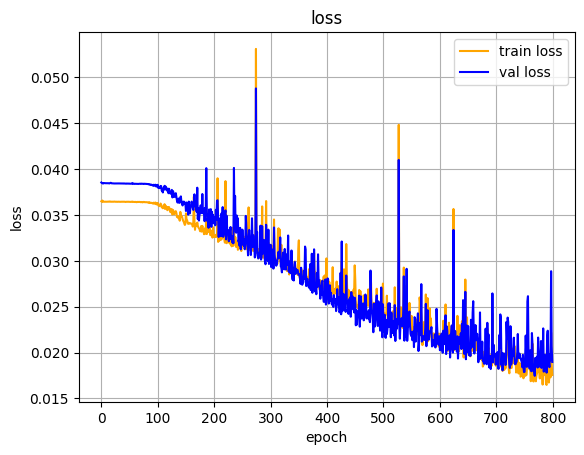

In [17]:
plt.plot(range(epochs), train_loss_value, c = 'orange', label = 'train loss')
plt.plot(range(epochs),val_loss_value, c='blue', label='val loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.legend()
plt.title('loss')
plt.show()

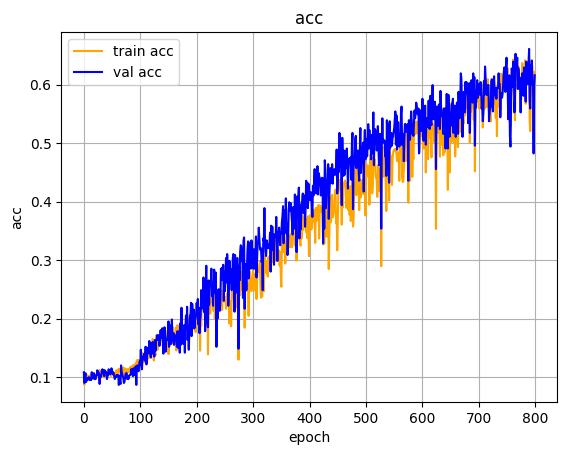

In [18]:
plt.clf()
plt.plot(range(epochs), train_acc_value, c = 'orange', label = 'train acc')
plt.plot(range(epochs), val_acc_value, c = 'blue', label = 'val acc')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.grid()
plt.legend()
plt.title('acc')
plt.show()

# ResNet

In [12]:
import torch
import torch.nn as nn
import os

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


    def save_checkpoint(cls, epoch, model, optimizer, history, path='checkpoint.pth'):
        state = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'history': history
        }
        torch.save(state, path)

    @classmethod
    def load_checkpoint(cls, path='checkpoint.pth'):
        if os.path.isfile(path):
            checkpoint = torch.load(path)
            return checkpoint['epoch'], checkpoint['model_state_dict'], checkpoint['optimizer_state_dict'], checkpoint['history']
        else:
            print("No checkpoint found.")
            return 0, None, None, None

# Usage
model1 = ResNet(ResidualBlock, [2, 2, 2, 2], num_classes=10)


In [15]:
import numpy as np
import torch
import random

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

import torch.optim as optim
import numpy as np

# 乱数の固定化
seed_everything()

# モデルインスタンス生成
model1 = ResNet(ResidualBlock, [2, 2, 2, 2], num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=0.001)

epochs = 200
train_loss_value1 = []
train_acc_value1 = []
val_loss_value1 = []
val_acc_value1 = []

for epoch in range(epochs):

    # モデルをトレーニングモードに設定
    model1.train()

    # トレーニングデータでの学習
    for (inputs, labels) in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model1(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # モデルを評価モードに設定
    model1.eval()

    # トレーニングデータでの損失と精度を計算
    train_loss, train_acc = evaluation(model1, train_loader)
    # バリデーションデータでの損失と精度を計算
    val_loss, val_acc = evaluation(model1, val_loader)

    # 結果を表示
    print(f"[{epoch + 1}/{epochs}] :: train loss: {train_loss:.4f}, train acc: {train_acc:.4f}, val loss: {val_loss:.4f}, val acc: {val_acc:.4f}")

    # 各エポックの結果を保存
    train_loss_value1.append(train_loss)
    train_acc_value1.append(train_acc)
    val_loss_value1.append(val_loss)
    val_acc_value1.append(val_acc)


100%|██████████| 38/38 [00:11<00:00,  3.39it/s]


[1/200] :: train loss: 0.0388, train acc: 0.1012, val loss: 0.0392, val acc: 0.1035


100%|██████████| 38/38 [00:11<00:00,  3.21it/s]


[2/200] :: train loss: 0.0371, train acc: 0.1070, val loss: 0.0394, val acc: 0.1002


100%|██████████| 38/38 [00:11<00:00,  3.22it/s]


[3/200] :: train loss: 0.0393, train acc: 0.1012, val loss: 0.0389, val acc: 0.1068


100%|██████████| 38/38 [00:11<00:00,  3.42it/s]


[4/200] :: train loss: 0.0371, train acc: 0.1066, val loss: 0.0389, val acc: 0.0968


100%|██████████| 38/38 [00:11<00:00,  3.22it/s]


[5/200] :: train loss: 0.0366, train acc: 0.1045, val loss: 0.0390, val acc: 0.1068


100%|██████████| 38/38 [00:11<00:00,  3.22it/s]


[6/200] :: train loss: 0.0366, train acc: 0.1004, val loss: 0.0387, val acc: 0.1002


100%|██████████| 38/38 [00:11<00:00,  3.23it/s]


[7/200] :: train loss: 0.0371, train acc: 0.1112, val loss: 0.0386, val acc: 0.0885


100%|██████████| 38/38 [00:11<00:00,  3.23it/s]


[8/200] :: train loss: 0.0378, train acc: 0.1070, val loss: 0.0392, val acc: 0.1068


100%|██████████| 38/38 [00:11<00:00,  3.23it/s]


[9/200] :: train loss: 0.0368, train acc: 0.1058, val loss: 0.0384, val acc: 0.1018


100%|██████████| 38/38 [00:11<00:00,  3.26it/s]


[10/200] :: train loss: 0.0402, train acc: 0.1050, val loss: 0.0386, val acc: 0.1002


100%|██████████| 38/38 [00:11<00:00,  3.40it/s]


[11/200] :: train loss: 0.0365, train acc: 0.1104, val loss: 0.0388, val acc: 0.1068


100%|██████████| 38/38 [00:11<00:00,  3.20it/s]


[12/200] :: train loss: 0.0394, train acc: 0.1058, val loss: 0.0396, val acc: 0.1135


100%|██████████| 38/38 [00:11<00:00,  3.23it/s]


[13/200] :: train loss: 0.0386, train acc: 0.1079, val loss: 0.0392, val acc: 0.0952


100%|██████████| 38/38 [00:11<00:00,  3.40it/s]


[14/200] :: train loss: 0.0381, train acc: 0.1245, val loss: 0.0403, val acc: 0.1068


100%|██████████| 38/38 [00:11<00:00,  3.20it/s]


[15/200] :: train loss: 0.0374, train acc: 0.1170, val loss: 0.0389, val acc: 0.1202


100%|██████████| 38/38 [00:11<00:00,  3.21it/s]


[16/200] :: train loss: 0.0437, train acc: 0.0950, val loss: 0.0418, val acc: 0.1068


100%|██████████| 38/38 [00:11<00:00,  3.21it/s]


[17/200] :: train loss: 0.0368, train acc: 0.1129, val loss: 0.0386, val acc: 0.0801


100%|██████████| 38/38 [00:11<00:00,  3.22it/s]


[18/200] :: train loss: 0.0369, train acc: 0.1091, val loss: 0.0387, val acc: 0.1068


100%|██████████| 38/38 [00:11<00:00,  3.22it/s]


[19/200] :: train loss: 0.0364, train acc: 0.1304, val loss: 0.0386, val acc: 0.0968


100%|██████████| 38/38 [00:12<00:00,  3.16it/s]


[20/200] :: train loss: 0.0371, train acc: 0.1108, val loss: 0.0390, val acc: 0.0968


100%|██████████| 38/38 [00:11<00:00,  3.24it/s]


[21/200] :: train loss: 0.0371, train acc: 0.1224, val loss: 0.0391, val acc: 0.1102


100%|██████████| 38/38 [00:11<00:00,  3.36it/s]


[22/200] :: train loss: 0.0362, train acc: 0.1349, val loss: 0.0379, val acc: 0.1469


100%|██████████| 38/38 [00:11<00:00,  3.19it/s]


[23/200] :: train loss: 0.0364, train acc: 0.1358, val loss: 0.0381, val acc: 0.1519


100%|██████████| 38/38 [00:11<00:00,  3.20it/s]


[24/200] :: train loss: 0.0364, train acc: 0.1312, val loss: 0.0380, val acc: 0.1519


100%|██████████| 38/38 [00:11<00:00,  3.39it/s]


[25/200] :: train loss: 0.0394, train acc: 0.1087, val loss: 0.0443, val acc: 0.1235


100%|██████████| 38/38 [00:11<00:00,  3.21it/s]


[26/200] :: train loss: 0.0421, train acc: 0.1299, val loss: 0.0432, val acc: 0.1419


100%|██████████| 38/38 [00:11<00:00,  3.22it/s]


[27/200] :: train loss: 0.0360, train acc: 0.1433, val loss: 0.0373, val acc: 0.1319


100%|██████████| 38/38 [00:11<00:00,  3.24it/s]


[28/200] :: train loss: 0.0363, train acc: 0.1591, val loss: 0.0375, val acc: 0.1803


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[29/200] :: train loss: 0.0391, train acc: 0.1416, val loss: 0.0416, val acc: 0.1469


100%|██████████| 38/38 [00:11<00:00,  3.22it/s]


[30/200] :: train loss: 0.0362, train acc: 0.1566, val loss: 0.0375, val acc: 0.1503


100%|██████████| 38/38 [00:11<00:00,  3.39it/s]


[31/200] :: train loss: 0.0348, train acc: 0.1649, val loss: 0.0350, val acc: 0.2087


100%|██████████| 38/38 [00:11<00:00,  3.40it/s]


[32/200] :: train loss: 0.0345, train acc: 0.1695, val loss: 0.0359, val acc: 0.1820


100%|██████████| 38/38 [00:11<00:00,  3.28it/s]


[33/200] :: train loss: 0.0331, train acc: 0.1870, val loss: 0.0393, val acc: 0.1636


100%|██████████| 38/38 [00:11<00:00,  3.23it/s]


[34/200] :: train loss: 0.0326, train acc: 0.2170, val loss: 0.0341, val acc: 0.2337


100%|██████████| 38/38 [00:11<00:00,  3.23it/s]


[35/200] :: train loss: 0.0355, train acc: 0.1641, val loss: 0.0408, val acc: 0.1736


100%|██████████| 38/38 [00:11<00:00,  3.23it/s]


[36/200] :: train loss: 0.0774, train acc: 0.1279, val loss: 0.1029, val acc: 0.1169


100%|██████████| 38/38 [00:11<00:00,  3.38it/s]


[37/200] :: train loss: 0.0341, train acc: 0.1983, val loss: 0.0374, val acc: 0.1886


100%|██████████| 38/38 [00:11<00:00,  3.22it/s]


[38/200] :: train loss: 0.0306, train acc: 0.2520, val loss: 0.0331, val acc: 0.2571


100%|██████████| 38/38 [00:11<00:00,  3.40it/s]


[39/200] :: train loss: 0.0417, train acc: 0.1933, val loss: 0.0593, val acc: 0.1553


100%|██████████| 38/38 [00:11<00:00,  3.39it/s]


[40/200] :: train loss: 0.0490, train acc: 0.1808, val loss: 0.0552, val acc: 0.1770


100%|██████████| 38/38 [00:11<00:00,  3.21it/s]


[41/200] :: train loss: 0.0303, train acc: 0.2865, val loss: 0.0311, val acc: 0.2888


100%|██████████| 38/38 [00:11<00:00,  3.22it/s]


[42/200] :: train loss: 0.0315, train acc: 0.2807, val loss: 0.0299, val acc: 0.3139


100%|██████████| 38/38 [00:11<00:00,  3.22it/s]


[43/200] :: train loss: 0.0304, train acc: 0.2874, val loss: 0.0368, val acc: 0.2371


100%|██████████| 38/38 [00:11<00:00,  3.22it/s]


[44/200] :: train loss: 0.0329, train acc: 0.2595, val loss: 0.0421, val acc: 0.2487


100%|██████████| 38/38 [00:11<00:00,  3.30it/s]


[45/200] :: train loss: 0.0328, train acc: 0.2811, val loss: 0.0426, val acc: 0.2487


100%|██████████| 38/38 [00:11<00:00,  3.22it/s]


[46/200] :: train loss: 0.0280, train acc: 0.3494, val loss: 0.0289, val acc: 0.3639


100%|██████████| 38/38 [00:11<00:00,  3.23it/s]


[47/200] :: train loss: 0.0289, train acc: 0.3240, val loss: 0.0310, val acc: 0.3389


100%|██████████| 38/38 [00:11<00:00,  3.23it/s]


[48/200] :: train loss: 0.0532, train acc: 0.1891, val loss: 0.0735, val acc: 0.1970


100%|██████████| 38/38 [00:11<00:00,  3.23it/s]


[49/200] :: train loss: 0.0269, train acc: 0.3619, val loss: 0.0272, val acc: 0.3973


100%|██████████| 38/38 [00:11<00:00,  3.23it/s]


[50/200] :: train loss: 0.0310, train acc: 0.3353, val loss: 0.0382, val acc: 0.3205


100%|██████████| 38/38 [00:11<00:00,  3.29it/s]


[51/200] :: train loss: 0.0242, train acc: 0.4386, val loss: 0.0251, val acc: 0.4691


100%|██████████| 38/38 [00:11<00:00,  3.24it/s]


[52/200] :: train loss: 0.0266, train acc: 0.3694, val loss: 0.0298, val acc: 0.3673


100%|██████████| 38/38 [00:11<00:00,  3.23it/s]


[53/200] :: train loss: 0.0250, train acc: 0.4169, val loss: 0.0271, val acc: 0.4257


100%|██████████| 38/38 [00:11<00:00,  3.23it/s]


[54/200] :: train loss: 0.0250, train acc: 0.4423, val loss: 0.0301, val acc: 0.4040


100%|██████████| 38/38 [00:11<00:00,  3.22it/s]


[55/200] :: train loss: 0.0225, train acc: 0.4786, val loss: 0.0258, val acc: 0.4441


100%|██████████| 38/38 [00:11<00:00,  3.22it/s]


[56/200] :: train loss: 0.0217, train acc: 0.4931, val loss: 0.0225, val acc: 0.5326


100%|██████████| 38/38 [00:11<00:00,  3.21it/s]


[57/200] :: train loss: 0.0258, train acc: 0.4115, val loss: 0.0296, val acc: 0.3957


100%|██████████| 38/38 [00:12<00:00,  3.12it/s]


[58/200] :: train loss: 0.0305, train acc: 0.3703, val loss: 0.0429, val acc: 0.3639


100%|██████████| 38/38 [00:11<00:00,  3.23it/s]


[59/200] :: train loss: 0.0218, train acc: 0.5040, val loss: 0.0243, val acc: 0.5075


100%|██████████| 38/38 [00:11<00:00,  3.22it/s]


[60/200] :: train loss: 0.0200, train acc: 0.5523, val loss: 0.0187, val acc: 0.5977


100%|██████████| 38/38 [00:11<00:00,  3.40it/s]


[61/200] :: train loss: 0.0227, train acc: 0.4731, val loss: 0.0261, val acc: 0.4407


100%|██████████| 38/38 [00:11<00:00,  3.22it/s]


[62/200] :: train loss: 0.0229, train acc: 0.4819, val loss: 0.0278, val acc: 0.4841


100%|██████████| 38/38 [00:11<00:00,  3.20it/s]


[63/200] :: train loss: 0.0314, train acc: 0.3353, val loss: 0.0439, val acc: 0.3088


100%|██████████| 38/38 [00:11<00:00,  3.21it/s]


[64/200] :: train loss: 0.0202, train acc: 0.5381, val loss: 0.0240, val acc: 0.4841


100%|██████████| 38/38 [00:11<00:00,  3.22it/s]


[65/200] :: train loss: 0.0239, train acc: 0.4769, val loss: 0.0313, val acc: 0.4457


100%|██████████| 38/38 [00:11<00:00,  3.23it/s]


[66/200] :: train loss: 0.0197, train acc: 0.5439, val loss: 0.0212, val acc: 0.5609


100%|██████████| 38/38 [00:11<00:00,  3.18it/s]


[67/200] :: train loss: 0.0236, train acc: 0.4556, val loss: 0.0337, val acc: 0.3873


100%|██████████| 38/38 [00:11<00:00,  3.23it/s]


[68/200] :: train loss: 0.0197, train acc: 0.5389, val loss: 0.0254, val acc: 0.5092


100%|██████████| 38/38 [00:11<00:00,  3.23it/s]


[69/200] :: train loss: 0.0187, train acc: 0.5706, val loss: 0.0211, val acc: 0.5426


100%|██████████| 38/38 [00:11<00:00,  3.21it/s]


[70/200] :: train loss: 0.0212, train acc: 0.5285, val loss: 0.0321, val acc: 0.4741


100%|██████████| 38/38 [00:11<00:00,  3.21it/s]


[71/200] :: train loss: 0.0173, train acc: 0.6018, val loss: 0.0215, val acc: 0.5910


100%|██████████| 38/38 [00:11<00:00,  3.22it/s]


[72/200] :: train loss: 0.0161, train acc: 0.6302, val loss: 0.0223, val acc: 0.5710


100%|██████████| 38/38 [00:11<00:00,  3.40it/s]


[73/200] :: train loss: 0.0164, train acc: 0.6164, val loss: 0.0189, val acc: 0.6110


100%|██████████| 38/38 [00:11<00:00,  3.39it/s]


[74/200] :: train loss: 0.0178, train acc: 0.5935, val loss: 0.0209, val acc: 0.5776


100%|██████████| 38/38 [00:11<00:00,  3.41it/s]


[75/200] :: train loss: 0.0197, train acc: 0.5664, val loss: 0.0249, val acc: 0.5593


100%|██████████| 38/38 [00:11<00:00,  3.23it/s]


[76/200] :: train loss: 0.0182, train acc: 0.5910, val loss: 0.0243, val acc: 0.5643


100%|██████████| 38/38 [00:11<00:00,  3.22it/s]


[77/200] :: train loss: 0.0163, train acc: 0.6364, val loss: 0.0171, val acc: 0.6661


100%|██████████| 38/38 [00:11<00:00,  3.24it/s]


[78/200] :: train loss: 0.0147, train acc: 0.6668, val loss: 0.0196, val acc: 0.6311


100%|██████████| 38/38 [00:11<00:00,  3.41it/s]


[79/200] :: train loss: 0.0226, train acc: 0.5364, val loss: 0.0303, val acc: 0.5442


100%|██████████| 38/38 [00:11<00:00,  3.39it/s]


[80/200] :: train loss: 0.0149, train acc: 0.6681, val loss: 0.0214, val acc: 0.6277


100%|██████████| 38/38 [00:11<00:00,  3.37it/s]


[81/200] :: train loss: 0.0155, train acc: 0.6451, val loss: 0.0234, val acc: 0.5726


100%|██████████| 38/38 [00:11<00:00,  3.40it/s]


[82/200] :: train loss: 0.0126, train acc: 0.7230, val loss: 0.0173, val acc: 0.6578


100%|██████████| 38/38 [00:11<00:00,  3.39it/s]


[83/200] :: train loss: 0.0181, train acc: 0.6231, val loss: 0.0241, val acc: 0.5910


100%|██████████| 38/38 [00:11<00:00,  3.29it/s]


[84/200] :: train loss: 0.0151, train acc: 0.6327, val loss: 0.0208, val acc: 0.6144


100%|██████████| 38/38 [00:11<00:00,  3.19it/s]


[85/200] :: train loss: 0.0132, train acc: 0.7001, val loss: 0.0192, val acc: 0.6544


100%|██████████| 38/38 [00:11<00:00,  3.22it/s]


[86/200] :: train loss: 0.0146, train acc: 0.6672, val loss: 0.0201, val acc: 0.6344


100%|██████████| 38/38 [00:11<00:00,  3.41it/s]


[87/200] :: train loss: 0.0138, train acc: 0.6914, val loss: 0.0206, val acc: 0.6544


100%|██████████| 38/38 [00:11<00:00,  3.41it/s]


[88/200] :: train loss: 0.0139, train acc: 0.6943, val loss: 0.0214, val acc: 0.6227


100%|██████████| 38/38 [00:11<00:00,  3.40it/s]


[89/200] :: train loss: 0.0125, train acc: 0.7185, val loss: 0.0184, val acc: 0.6778


100%|██████████| 38/38 [00:11<00:00,  3.37it/s]


[90/200] :: train loss: 0.0125, train acc: 0.7205, val loss: 0.0181, val acc: 0.6177


100%|██████████| 38/38 [00:11<00:00,  3.37it/s]


[91/200] :: train loss: 0.0125, train acc: 0.7168, val loss: 0.0226, val acc: 0.6144


100%|██████████| 38/38 [00:11<00:00,  3.37it/s]


[92/200] :: train loss: 0.0111, train acc: 0.7497, val loss: 0.0187, val acc: 0.6745


100%|██████████| 38/38 [00:11<00:00,  3.24it/s]


[93/200] :: train loss: 0.0130, train acc: 0.7051, val loss: 0.0253, val acc: 0.6144


100%|██████████| 38/38 [00:11<00:00,  3.24it/s]


[94/200] :: train loss: 0.0154, train acc: 0.6614, val loss: 0.0280, val acc: 0.5860


100%|██████████| 38/38 [00:11<00:00,  3.27it/s]


[95/200] :: train loss: 0.0120, train acc: 0.7239, val loss: 0.0178, val acc: 0.6745


100%|██████████| 38/38 [00:11<00:00,  3.23it/s]


[96/200] :: train loss: 0.0110, train acc: 0.7447, val loss: 0.0193, val acc: 0.6795


100%|██████████| 38/38 [00:11<00:00,  3.25it/s]


[97/200] :: train loss: 0.0106, train acc: 0.7589, val loss: 0.0186, val acc: 0.7012


100%|██████████| 38/38 [00:11<00:00,  3.23it/s]


[98/200] :: train loss: 0.0109, train acc: 0.7543, val loss: 0.0183, val acc: 0.6878


100%|██████████| 38/38 [00:11<00:00,  3.24it/s]


[99/200] :: train loss: 0.0127, train acc: 0.7222, val loss: 0.0244, val acc: 0.6110


100%|██████████| 38/38 [00:11<00:00,  3.21it/s]


[100/200] :: train loss: 0.0121, train acc: 0.7359, val loss: 0.0274, val acc: 0.6027


100%|██████████| 38/38 [00:11<00:00,  3.21it/s]


[101/200] :: train loss: 0.0108, train acc: 0.7593, val loss: 0.0197, val acc: 0.6711


100%|██████████| 38/38 [00:11<00:00,  3.23it/s]


[102/200] :: train loss: 0.0107, train acc: 0.7576, val loss: 0.0208, val acc: 0.6711


100%|██████████| 38/38 [00:11<00:00,  3.23it/s]


[103/200] :: train loss: 0.0117, train acc: 0.7351, val loss: 0.0191, val acc: 0.6644


100%|██████████| 38/38 [00:11<00:00,  3.36it/s]


[104/200] :: train loss: 0.0112, train acc: 0.7609, val loss: 0.0192, val acc: 0.6711


100%|██████████| 38/38 [00:11<00:00,  3.25it/s]


[105/200] :: train loss: 0.0098, train acc: 0.7813, val loss: 0.0157, val acc: 0.7162


100%|██████████| 38/38 [00:11<00:00,  3.40it/s]


[106/200] :: train loss: 0.0090, train acc: 0.8042, val loss: 0.0172, val acc: 0.7028


100%|██████████| 38/38 [00:11<00:00,  3.22it/s]


[107/200] :: train loss: 0.0099, train acc: 0.7801, val loss: 0.0191, val acc: 0.6861


100%|██████████| 38/38 [00:11<00:00,  3.22it/s]


[108/200] :: train loss: 0.0094, train acc: 0.7972, val loss: 0.0188, val acc: 0.6878


100%|██████████| 38/38 [00:11<00:00,  3.20it/s]


[109/200] :: train loss: 0.0117, train acc: 0.7309, val loss: 0.0236, val acc: 0.6477


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[110/200] :: train loss: 0.0102, train acc: 0.7730, val loss: 0.0202, val acc: 0.6845


100%|██████████| 38/38 [00:11<00:00,  3.23it/s]


[111/200] :: train loss: 0.0083, train acc: 0.8159, val loss: 0.0175, val acc: 0.7129


100%|██████████| 38/38 [00:11<00:00,  3.23it/s]


[112/200] :: train loss: 0.0085, train acc: 0.8088, val loss: 0.0184, val acc: 0.6928


100%|██████████| 38/38 [00:11<00:00,  3.22it/s]


[113/200] :: train loss: 0.0086, train acc: 0.8080, val loss: 0.0180, val acc: 0.6978


100%|██████████| 38/38 [00:11<00:00,  3.22it/s]


[114/200] :: train loss: 0.0094, train acc: 0.7872, val loss: 0.0165, val acc: 0.7012


100%|██████████| 38/38 [00:11<00:00,  3.22it/s]


[115/200] :: train loss: 0.0071, train acc: 0.8338, val loss: 0.0153, val acc: 0.7362


100%|██████████| 38/38 [00:11<00:00,  3.20it/s]


[116/200] :: train loss: 0.0082, train acc: 0.8130, val loss: 0.0182, val acc: 0.6878


100%|██████████| 38/38 [00:11<00:00,  3.37it/s]


[117/200] :: train loss: 0.0084, train acc: 0.8080, val loss: 0.0193, val acc: 0.6978


100%|██████████| 38/38 [00:11<00:00,  3.26it/s]


[118/200] :: train loss: 0.0073, train acc: 0.8409, val loss: 0.0180, val acc: 0.7279


100%|██████████| 38/38 [00:11<00:00,  3.41it/s]


[119/200] :: train loss: 0.0068, train acc: 0.8505, val loss: 0.0182, val acc: 0.7062


100%|██████████| 38/38 [00:11<00:00,  3.23it/s]


[120/200] :: train loss: 0.0072, train acc: 0.8384, val loss: 0.0193, val acc: 0.6912


100%|██████████| 38/38 [00:11<00:00,  3.22it/s]


[121/200] :: train loss: 0.0070, train acc: 0.8480, val loss: 0.0175, val acc: 0.7279


100%|██████████| 38/38 [00:11<00:00,  3.19it/s]


[122/200] :: train loss: 0.0096, train acc: 0.7868, val loss: 0.0286, val acc: 0.6711


100%|██████████| 38/38 [00:11<00:00,  3.22it/s]


[123/200] :: train loss: 0.0081, train acc: 0.8230, val loss: 0.0199, val acc: 0.7245


100%|██████████| 38/38 [00:11<00:00,  3.17it/s]


[124/200] :: train loss: 0.0083, train acc: 0.8209, val loss: 0.0224, val acc: 0.6828


100%|██████████| 38/38 [00:11<00:00,  3.23it/s]


[125/200] :: train loss: 0.0069, train acc: 0.8438, val loss: 0.0223, val acc: 0.7062


100%|██████████| 38/38 [00:11<00:00,  3.22it/s]


[126/200] :: train loss: 0.0080, train acc: 0.8309, val loss: 0.0216, val acc: 0.7145


100%|██████████| 38/38 [00:11<00:00,  3.23it/s]


[127/200] :: train loss: 0.0075, train acc: 0.8342, val loss: 0.0242, val acc: 0.6895


100%|██████████| 38/38 [00:11<00:00,  3.22it/s]


[128/200] :: train loss: 0.0068, train acc: 0.8480, val loss: 0.0198, val acc: 0.7212


100%|██████████| 38/38 [00:11<00:00,  3.23it/s]


[129/200] :: train loss: 0.0083, train acc: 0.8222, val loss: 0.0221, val acc: 0.7112


100%|██████████| 38/38 [00:11<00:00,  3.23it/s]


[130/200] :: train loss: 0.0063, train acc: 0.8601, val loss: 0.0229, val acc: 0.7112


100%|██████████| 38/38 [00:11<00:00,  3.22it/s]


[131/200] :: train loss: 0.0067, train acc: 0.8534, val loss: 0.0200, val acc: 0.7045


100%|██████████| 38/38 [00:11<00:00,  3.37it/s]


[132/200] :: train loss: 0.0070, train acc: 0.8442, val loss: 0.0215, val acc: 0.7112


100%|██████████| 38/38 [00:11<00:00,  3.27it/s]


[133/200] :: train loss: 0.0070, train acc: 0.8392, val loss: 0.0176, val acc: 0.7429


100%|██████████| 38/38 [00:11<00:00,  3.40it/s]


[134/200] :: train loss: 0.0071, train acc: 0.8388, val loss: 0.0196, val acc: 0.7045


100%|██████████| 38/38 [00:11<00:00,  3.19it/s]


[135/200] :: train loss: 0.0069, train acc: 0.8467, val loss: 0.0183, val acc: 0.7446


100%|██████████| 38/38 [00:11<00:00,  3.23it/s]


[136/200] :: train loss: 0.0070, train acc: 0.8492, val loss: 0.0225, val acc: 0.7112


100%|██████████| 38/38 [00:11<00:00,  3.36it/s]


[137/200] :: train loss: 0.0066, train acc: 0.8605, val loss: 0.0168, val acc: 0.7396


100%|██████████| 38/38 [00:11<00:00,  3.41it/s]


[138/200] :: train loss: 0.0068, train acc: 0.8476, val loss: 0.0208, val acc: 0.6878


100%|██████████| 38/38 [00:11<00:00,  3.41it/s]


[139/200] :: train loss: 0.0055, train acc: 0.8792, val loss: 0.0211, val acc: 0.7129


100%|██████████| 38/38 [00:11<00:00,  3.40it/s]


[140/200] :: train loss: 0.0060, train acc: 0.8659, val loss: 0.0195, val acc: 0.7446


100%|██████████| 38/38 [00:11<00:00,  3.41it/s]


[141/200] :: train loss: 0.0058, train acc: 0.8680, val loss: 0.0163, val acc: 0.7679


100%|██████████| 38/38 [00:11<00:00,  3.41it/s]


[142/200] :: train loss: 0.0058, train acc: 0.8709, val loss: 0.0209, val acc: 0.7179


100%|██████████| 38/38 [00:11<00:00,  3.42it/s]


[143/200] :: train loss: 0.0066, train acc: 0.8555, val loss: 0.0172, val acc: 0.7212


100%|██████████| 38/38 [00:11<00:00,  3.41it/s]


[144/200] :: train loss: 0.0058, train acc: 0.8676, val loss: 0.0191, val acc: 0.7329


100%|██████████| 38/38 [00:11<00:00,  3.42it/s]


[145/200] :: train loss: 0.0078, train acc: 0.8213, val loss: 0.0294, val acc: 0.6461


100%|██████████| 38/38 [00:11<00:00,  3.37it/s]


[146/200] :: train loss: 0.0056, train acc: 0.8817, val loss: 0.0226, val acc: 0.7028


100%|██████████| 38/38 [00:11<00:00,  3.41it/s]


[147/200] :: train loss: 0.0050, train acc: 0.8909, val loss: 0.0222, val acc: 0.7212


100%|██████████| 38/38 [00:11<00:00,  3.32it/s]


[148/200] :: train loss: 0.0054, train acc: 0.8825, val loss: 0.0166, val acc: 0.7429


100%|██████████| 38/38 [00:11<00:00,  3.24it/s]


[149/200] :: train loss: 0.0097, train acc: 0.8005, val loss: 0.0386, val acc: 0.6160


100%|██████████| 38/38 [00:11<00:00,  3.33it/s]


[150/200] :: train loss: 0.0057, train acc: 0.8705, val loss: 0.0180, val acc: 0.7412


100%|██████████| 38/38 [00:11<00:00,  3.24it/s]


[151/200] :: train loss: 0.0053, train acc: 0.8913, val loss: 0.0225, val acc: 0.7295


100%|██████████| 38/38 [00:11<00:00,  3.23it/s]


[152/200] :: train loss: 0.0055, train acc: 0.8796, val loss: 0.0193, val acc: 0.7479


100%|██████████| 38/38 [00:11<00:00,  3.22it/s]


[153/200] :: train loss: 0.0052, train acc: 0.8809, val loss: 0.0186, val acc: 0.7479


100%|██████████| 38/38 [00:11<00:00,  3.22it/s]


[154/200] :: train loss: 0.0055, train acc: 0.8821, val loss: 0.0204, val acc: 0.7346


100%|██████████| 38/38 [00:11<00:00,  3.23it/s]


[155/200] :: train loss: 0.0052, train acc: 0.8917, val loss: 0.0171, val acc: 0.7579


100%|██████████| 38/38 [00:11<00:00,  3.23it/s]


[156/200] :: train loss: 0.0069, train acc: 0.8576, val loss: 0.0259, val acc: 0.7145


100%|██████████| 38/38 [00:11<00:00,  3.31it/s]


[157/200] :: train loss: 0.0049, train acc: 0.8896, val loss: 0.0189, val acc: 0.7412


100%|██████████| 38/38 [00:11<00:00,  3.31it/s]


[158/200] :: train loss: 0.0047, train acc: 0.8984, val loss: 0.0201, val acc: 0.7429


100%|██████████| 38/38 [00:11<00:00,  3.29it/s]


[159/200] :: train loss: 0.0051, train acc: 0.8917, val loss: 0.0225, val acc: 0.7346


100%|██████████| 38/38 [00:11<00:00,  3.24it/s]


[160/200] :: train loss: 0.0060, train acc: 0.8655, val loss: 0.0246, val acc: 0.6978


100%|██████████| 38/38 [00:11<00:00,  3.41it/s]


[161/200] :: train loss: 0.0054, train acc: 0.8796, val loss: 0.0198, val acc: 0.7245


100%|██████████| 38/38 [00:11<00:00,  3.19it/s]


[162/200] :: train loss: 0.0051, train acc: 0.8913, val loss: 0.0205, val acc: 0.7212


100%|██████████| 38/38 [00:11<00:00,  3.24it/s]


[163/200] :: train loss: 0.0048, train acc: 0.8938, val loss: 0.0205, val acc: 0.7245


100%|██████████| 38/38 [00:11<00:00,  3.31it/s]


[164/200] :: train loss: 0.0054, train acc: 0.8776, val loss: 0.0231, val acc: 0.7162


100%|██████████| 38/38 [00:11<00:00,  3.34it/s]


[165/200] :: train loss: 0.0047, train acc: 0.8955, val loss: 0.0194, val acc: 0.7412


100%|██████████| 38/38 [00:11<00:00,  3.28it/s]


[166/200] :: train loss: 0.0056, train acc: 0.8776, val loss: 0.0204, val acc: 0.7212


100%|██████████| 38/38 [00:11<00:00,  3.22it/s]


[167/200] :: train loss: 0.0045, train acc: 0.8988, val loss: 0.0219, val acc: 0.7262


100%|██████████| 38/38 [00:11<00:00,  3.41it/s]


[168/200] :: train loss: 0.0053, train acc: 0.8925, val loss: 0.0229, val acc: 0.7195


100%|██████████| 38/38 [00:11<00:00,  3.25it/s]


[169/200] :: train loss: 0.0049, train acc: 0.8950, val loss: 0.0240, val acc: 0.6962


100%|██████████| 38/38 [00:11<00:00,  3.24it/s]


[170/200] :: train loss: 0.0045, train acc: 0.9034, val loss: 0.0237, val acc: 0.7112


100%|██████████| 38/38 [00:11<00:00,  3.27it/s]


[171/200] :: train loss: 0.0050, train acc: 0.8838, val loss: 0.0255, val acc: 0.7145


100%|██████████| 38/38 [00:11<00:00,  3.22it/s]


[172/200] :: train loss: 0.0045, train acc: 0.9042, val loss: 0.0219, val acc: 0.7145


100%|██████████| 38/38 [00:11<00:00,  3.21it/s]


[173/200] :: train loss: 0.0043, train acc: 0.9117, val loss: 0.0186, val acc: 0.7579


100%|██████████| 38/38 [00:11<00:00,  3.23it/s]


[174/200] :: train loss: 0.0053, train acc: 0.8850, val loss: 0.0230, val acc: 0.7429


100%|██████████| 38/38 [00:11<00:00,  3.22it/s]


[175/200] :: train loss: 0.0043, train acc: 0.9063, val loss: 0.0199, val acc: 0.7396


100%|██████████| 38/38 [00:11<00:00,  3.19it/s]


[176/200] :: train loss: 0.0057, train acc: 0.8696, val loss: 0.0276, val acc: 0.7012


100%|██████████| 38/38 [00:11<00:00,  3.22it/s]


[177/200] :: train loss: 0.0047, train acc: 0.8955, val loss: 0.0215, val acc: 0.7312


100%|██████████| 38/38 [00:11<00:00,  3.29it/s]


[178/200] :: train loss: 0.0043, train acc: 0.9071, val loss: 0.0199, val acc: 0.7496


100%|██████████| 38/38 [00:11<00:00,  3.32it/s]


[179/200] :: train loss: 0.0050, train acc: 0.8905, val loss: 0.0249, val acc: 0.7212


100%|██████████| 38/38 [00:11<00:00,  3.18it/s]


[180/200] :: train loss: 0.0044, train acc: 0.9067, val loss: 0.0218, val acc: 0.7446


100%|██████████| 38/38 [00:11<00:00,  3.23it/s]


[181/200] :: train loss: 0.0051, train acc: 0.8946, val loss: 0.0196, val acc: 0.7179


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[182/200] :: train loss: 0.0044, train acc: 0.9109, val loss: 0.0177, val acc: 0.7446


100%|██████████| 38/38 [00:11<00:00,  3.22it/s]


[183/200] :: train loss: 0.0054, train acc: 0.8800, val loss: 0.0318, val acc: 0.6628


100%|██████████| 38/38 [00:11<00:00,  3.22it/s]


[184/200] :: train loss: 0.0040, train acc: 0.9071, val loss: 0.0200, val acc: 0.7563


100%|██████████| 38/38 [00:11<00:00,  3.26it/s]


[185/200] :: train loss: 0.0048, train acc: 0.8950, val loss: 0.0213, val acc: 0.7245


100%|██████████| 38/38 [00:11<00:00,  3.35it/s]


[186/200] :: train loss: 0.0045, train acc: 0.9071, val loss: 0.0220, val acc: 0.7179


100%|██████████| 38/38 [00:11<00:00,  3.23it/s]


[187/200] :: train loss: 0.0045, train acc: 0.8992, val loss: 0.0210, val acc: 0.7145


100%|██████████| 38/38 [00:11<00:00,  3.40it/s]


[188/200] :: train loss: 0.0041, train acc: 0.9105, val loss: 0.0204, val acc: 0.7462


100%|██████████| 38/38 [00:11<00:00,  3.41it/s]


[189/200] :: train loss: 0.0050, train acc: 0.8896, val loss: 0.0256, val acc: 0.7195


100%|██████████| 38/38 [00:11<00:00,  3.22it/s]


[190/200] :: train loss: 0.0046, train acc: 0.8971, val loss: 0.0213, val acc: 0.7479


100%|██████████| 38/38 [00:11<00:00,  3.23it/s]


[191/200] :: train loss: 0.0036, train acc: 0.9279, val loss: 0.0185, val acc: 0.7596


100%|██████████| 38/38 [00:11<00:00,  3.22it/s]


[192/200] :: train loss: 0.0042, train acc: 0.9080, val loss: 0.0193, val acc: 0.7546


100%|██████████| 38/38 [00:11<00:00,  3.22it/s]


[193/200] :: train loss: 0.0043, train acc: 0.9005, val loss: 0.0263, val acc: 0.7279


100%|██████████| 38/38 [00:11<00:00,  3.21it/s]


[194/200] :: train loss: 0.0044, train acc: 0.9030, val loss: 0.0220, val acc: 0.7412


100%|██████████| 38/38 [00:11<00:00,  3.23it/s]


[195/200] :: train loss: 0.0040, train acc: 0.9092, val loss: 0.0218, val acc: 0.7329


100%|██████████| 38/38 [00:11<00:00,  3.22it/s]


[196/200] :: train loss: 0.0044, train acc: 0.8980, val loss: 0.0264, val acc: 0.7145


100%|██████████| 38/38 [00:11<00:00,  3.40it/s]


[197/200] :: train loss: 0.0045, train acc: 0.9025, val loss: 0.0239, val acc: 0.7329


100%|██████████| 38/38 [00:11<00:00,  3.23it/s]


[198/200] :: train loss: 0.0039, train acc: 0.9167, val loss: 0.0203, val acc: 0.7496


100%|██████████| 38/38 [00:11<00:00,  3.43it/s]


[199/200] :: train loss: 0.0041, train acc: 0.9100, val loss: 0.0217, val acc: 0.7145


100%|██████████| 38/38 [00:11<00:00,  3.42it/s]


[200/200] :: train loss: 0.0036, train acc: 0.9184, val loss: 0.0207, val acc: 0.7362


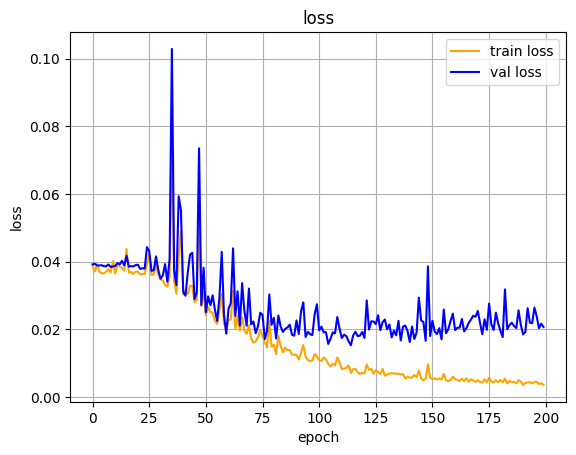

In [16]:

plt.plot(range(epochs), train_loss_value1, c = 'orange', label = 'train loss')
plt.plot(range(epochs), val_loss_value1, c='blue', label='val loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.legend()
plt.title('loss')
plt.show()


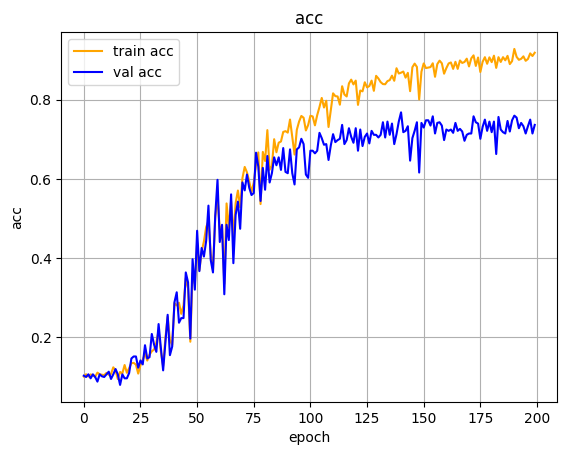

In [17]:
plt.clf()
plt.plot(range(epochs), train_acc_value1, c = 'orange', label = 'train acc')
plt.plot(range(epochs), val_acc_value1, c = 'blue', label = 'val acc')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.grid()
plt.legend()
plt.title('acc')
plt.show()

モデルのパラメータを保存とロード

In [63]:
model_pram = model1.state_dict()
torch.save(model1.state_dict(), '/src/openhouse2024_competition/model_weight.pth')

eval_model = ResNet(ResidualBlock, [2, 2, 2, 2], num_classes=10)
eval_model.load_state_dict(model_pram)

<All keys matched successfully>

推論用のデータの作成

In [64]:
import pandas as pd
import os
import shutil

# testディレクトリのパス
test_dir = "/src/openhouse2024_competition/test"

# 変更後のディレクトリの作成
# testv2に変更ごの内容を保存する
save_dir = "/src/openhouse2024_competition/testv2"

# 既にディレクトリが作成されている場合は作成処理を行わない
if os.path.exists(save_dir):
    pass
else:
    os.mkdir(save_dir)

# images_info.csvの読み込み
img_data = pd.read_csv(test_dir + '/images_info.csv', header = None)
img_data.head()


,0,1
0,test_001.png,ね
1,test_002.png,ろ
2,test_003.png,ろ
3,test_004.png,あ
4,test_005.png,は


In [65]:
# クラス名を所得
# 変更箇所（sorted関数を追加）
classes = sorted(img_data[1].unique())
classes

['あ', 'い', 'お', 'に', 'ぬ', 'ね', 'は', 'め', 'れ', 'ろ']

In [66]:
for class_name in classes:

    # class_name毎のディレクトリのパス
    class_dir = save_dir + "/" + class_name

    # 既にディレクトリが作成されている場合は作成処理を行わない
    if os.path.exists(class_dir):
        pass
    else:
        os.mkdir(class_dir)

    # class_nameごとのimageファイルの抽出とリスト化
    img_list = img_data[img_data[1] == class_name][0].to_list()

    # 該当の画像をtestv2の各クラスディレクトリにコピー
    for img in img_list:
        shutil.copy(test_dir + "/images/" + img, class_dir)

推論用Dataloaderの作成

In [67]:
# testデータのパス
test_dir = save_dir

# データの前処理の定義
trans = transforms.Compose([transforms.ToTensor()])

# データセットが格納されている場所を参照してdatasetオブジェクトを作成。このときに前処理を適用する
test_dataset = ImageFolder(root = test_dir, transform = trans)

# Dataloaderの作成
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = len(test_dataset.samples))


学習したモデルで推論

推論した結果、推論後のラベルが出力できればOK

In [68]:
eval_model.eval()

with torch.no_grad():

    sum_correct = 0

    for inputs, labels in test_loader:
        output = eval_model(inputs)
        _, predicted_label = torch.max(output, 1)
        sum_correct += (predicted_label == labels).sum().item()

    accuracy = sum_correct / len(test_loader.dataset)

print(f"予測結果(先頭10個だけ)：{predicted_label[:10]}")
print(f"正解率：{accuracy * 100}%")

予測結果(先頭10個だけ)：tensor([2, 2, 9, 2, 2, 2, 2, 2, 2, 2])
正解率：10.100000000000001%


推論結果をCSVに出力

In [70]:
# 変更箇所（以下のコードブロックを追加）
predicted_label_str = []

if 'a' in classes:
    hira_label = ['あ', 'は', 'い', 'め', 'ね', 'に', 'ぬ', 'お', 'れ', 'ろ']
    label_dict = {alpha : hira for alpha, hira in zip(classes, hira_label)}

    labels = list(label_dict.values())
    for p_label in predicted_label:
        predicted_label_str.append(labels[p_label])

else:
    for p_label in predicted_label:
        predicted_label_str.append(classes[p_label])

最終的な出力は数値ではなく、数値に対応した平仮名がCSVに出力されるようになっている。

submit.csvが作成できたら平仮名が一列に並んでいる状態であるか確認して欲しい。

In [71]:
predict = pd.DataFrame(predicted_label_str)
predict.to_csv("/src/openhouse2024_competition/submit.csv", header = None, index = False)